In [8]:
from ott.solvers import linear
from ott.geometry import pointcloud, geometry, epsilon_scheduler
from ott import utils
import jax.numpy as jnp
import jax
from jaxtyping import Array, Float, Int
from ott.solvers.linear.implicit_differentiation import ImplicitDiff
import matplotlib.pyplot as plt
import optax
import functools
from tqdm import tqdm
from jax import config

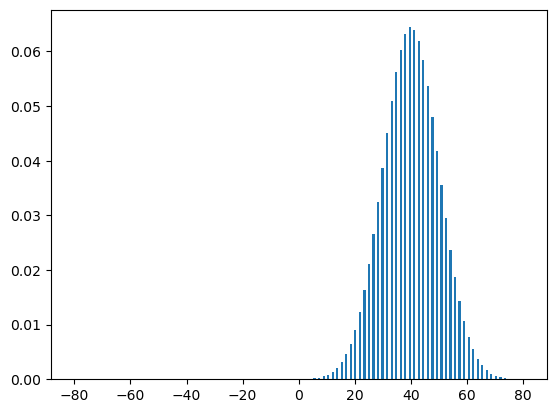

In [9]:
# initialize a gaussian kernel, mu_true, on domain X
size = 100
sigma = 0.125
X = jnp.linspace(-1, 1, 100).astype(jnp.float32)
mu_true = jax.nn.softmax((-(X - 0.5)**2)/(2 * (sigma ** 2))) # gaussian kernel (sigma = 0.125, mean = 0.5)
plt.bar(X * 80, mu_true) # scale up domain for visualization
plt.show()

In [10]:
# default epsilon
X = X.astype(jnp.float32)
X_reshaped = X.reshape((X.shape[0], 1)).astype(jnp.float32)
pc = pointcloud.PointCloud(X_reshaped, X_reshaped, epsilon=None)
eps_default = pc.epsilon
print(eps_default)

0.04023559


In [11]:
solve_fn = jax.jit(linear.solve, static_argnames=['max_iterations', 'progress_fn', 'tau_a', 'tau_b'])
progress_fn = utils.default_progress_fn()
implicit_diff = ImplicitDiff(solver_kwargs={'max_steps': 5000})

"""
Compute regularized ot cost for transporting between marginals mu and mu_true on geometry x
"""
def ot_marginal_loss(mu: Float[Array, "n "], mu_true: Float[Array, "n "], x: Float[Array, "n d"], epsilon: Float, tau: Float):
    geom = pointcloud.PointCloud(x, x, epsilon=epsilon)
    #print(f"$\epsilon$: {geom.epsilon}")
    ot = solve_fn(geom, implicit_diff=ImplicitDiff(), a=mu, b=mu_true, tau_a=tau, tau_b=tau, max_iterations=5000)
    return ot.reg_ot_cost

def ot_marginal_loss_geom(mu: Float[Array, "n "], mu_true: Float[Array, "n "], x: Float[Array, "n d"], epsilon: Float):
    '''
    Compute reg_ot_cost using geometry.Geometry
    '''
    pc = pointcloud.PointCloud(x, x, epsilon=epsilon)
    geom = geometry.Geometry(pc.cost_matrix)
    ot = solve_fn(geom, implicit_diff=ImplicitDiff(), a=mu, b=mu_true, max_iterations=5000)
    return ot.reg_ot_cost

"""
Compute W2 distance between marginals mu and mu_true on geometry x
"""
def ot_marginal_loss_w2(mu: Float[Array, "n "], mu_true: Float[Array, "n "], x: Float[Array, "n d"], epsilon: Float):
    geom = pointcloud.PointCloud(x, x, epsilon=epsilon)
    ot = solve_fn(geom, implicit_diff=ImplicitDiff(), a=mu, b=mu_true, max_iterations=5000)
    return jnp.dot(ot.geom.cost_matrix.ravel(), ot.matrix.ravel())

"""
ot primal cost for transporting between marginals mu and mu_true on geometry x
"""
def ot_marginal_loss_primal(mu: Float[Array, "n "], mu_true: Float[Array, "n "], x: Float[Array, "n d"], epsilon: Float):
    geom = pointcloud.PointCloud(x, x, epsilon=epsilon)
    ot = solve_fn(geom, implicit_diff=ImplicitDiff(), a=mu, b=mu_true, max_iterations=5000)
    return ot.primal_cost

"""
1-d gaussian kernel with center c, standard deviation sigma, domain
"""
def gaussian_kernel(c, sigma, X):
    mu = jnp.exp(-((X-c)**2)/(2 * sigma**2))
    mu /= jnp.sum(mu)
    return mu

"""
learning the center of a gaussian marginal - doesn't work
"""
def loss(c: Array, mu_true: Float[Array, "n "], sigma: Float=5.0, X: Float[Array, "n "] = X):
    log_mu = -((X - c) ** 2) / (2 * sigma ** 2)  # Log-space Gaussian kernel
    mu = jnp.exp(log_mu - jnp.logsumexp(log_mu))  # More numerically stable normalization
    
    return jnp.mean(mu)
    #return ot_marginal_loss(mu, mu_true, X.reshape(X.shape[0], 1).astype(float)) # return cost to transport to mu_true

"""
loss function for logits of a probability distribution
"""
def logit_loss(theta: Float[Array, "n"], mu_true: Float[Array, "n "], X: Float[Array, "n 1 "] = X):
    mu = jax.nn.softmax(theta)
    return ot_marginal_loss(mu, mu_true, X, None)

In [12]:
class Scheduler:
    def __init__(self, target, init, decay, decay_after=1000):
        self.target = target
        self.init = init
        self.decay = decay
        self.decay_after = decay_after
        
    def get_epsilon(self, it: Int):
        """
        At training step it, get a value of epsilon
        """
        epsilon = self.init * self.target
        epsilon = jax.lax.cond(it > self.decay_after,
                     lambda t : jax.lax.cond(t - self.decay * (it - self.decay_after) > self.target, lambda s : t - self.decay * (it - self.decay_after), lambda s: self.target, None),
                     lambda t: t,
                     epsilon)  # linear decay   
        return epsilon

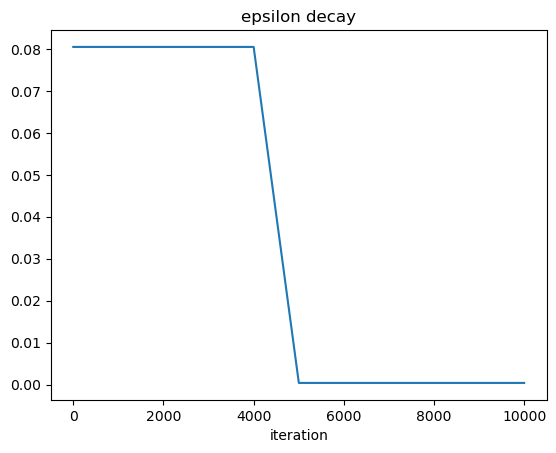

In [13]:
xs = jnp.arange(0, 10000, 1)
eps_scheduler = Scheduler(eps_default * 0.01, 200, 8.006883e-05, decay_after=4000)
get_epsilon = jax.jit(eps_scheduler.get_epsilon)
ys = [float(get_epsilon(x)) for x in xs]
plt.plot(xs, ys)
plt.title("epsilon decay")
plt.xlabel("iteration")
plt.show()

In [14]:
"""
l2 distance between logits and probability distribution
"""
def logit_l2_loss(theta: Float[Array, "n "], marginal: Float[Array, "n "]):
    mu = jax.nn.softmax(theta)
    return jnp.sqrt(jnp.sum((mu - marginal)**2))

"""
learn the logits of a probability distribution

epsilon - regularization parameter of ot solver, passing None yields the default 
value based on the stddev of the cost matrix
"""
def learn_marginal_logits(marginal: Float[Array, "n "], X: Float[Array, "n "], marginal_comparison_fn, seed=42, 
                          training_steps=500, epsilon: Float=None, tau: Float=1.0, lr=1e-3, init_from_mu_true=False, use_adam=True, use_stabilization=False, scheduler: Scheduler=None):
    solver = optax.adam(learning_rate=lr)
    key = jax.random.PRNGKey(42)
    key, subkey = jax.random.split(key)
    
    if init_from_mu_true:  # initialize at the true marginal
        mu_true_logits = jnp.log(mu_true)
        theta_init = mu_true_logits
    else:
        theta_init = jnp.zeros(shape=X.shape[0]) # uniform initialization
    
    # initialize solver
    theta = theta_init
    opt_state = solver.init(theta)
    
    # convert everything to float64
    theta = theta.astype(jnp.float64)
    X = X.astype(jnp.float64)
    
    X_reshaped = X.reshape((X.shape[0], 1)).astype(jnp.float64)
    
    # create loss function
    def loss_fn(theta: Float[Array, "n"], mu_true: Float[Array, "n "], X: Float[Array, "n 1 "], epsilon: Float, tau: Float):
        mu = jax.nn.softmax(theta)
        return marginal_comparison_fn(mu, mu_true, X, epsilon, tau)
    
    loss_fn = functools.partial(loss_fn, mu_true=marginal, X=X_reshaped, tau=tau)
    grad_loss_fn = jax.value_and_grad(loss_fn)
    
    @jax.jit
    def make_step_adam(theta, epsilon, opt_state):
        loss_val, grads = grad_loss_fn(theta, epsilon=epsilon)
        updates, opt_state = solver.update(grads, opt_state)
        theta = optax.apply_updates(theta, updates)
        return loss_val, theta, opt_state
    
    @jax.jit
    def make_step(theta, epsilon, opt_state):
        loss_val, grads = grad_loss_fn(theta, epsilon)
        theta = theta - lr * grads
        return loss_val, theta, None
    
    @jax.jit
    def make_step_stabilized(theta, epsilon, opt_state):
        loss_val, grads = grad_loss_fn(theta, epsilon)
        theta = theta - lr * grads
        
        # stabilize by subtracting max from theta
        theta = theta - jnp.max(theta) # softmax(X - c) = softmax(X) 
        
        return loss_val, theta, None
    
    if use_adam:
        make_step = make_step_adam
    if use_stabilization:
        make_step = make_step_stabilized
    
    w2_loss_vals = []
    l2_loss_vals = []
    thetas = {}
    if scheduler != None:
        get_epsilon = jax.jit(scheduler.get_epsilon)
    for step in tqdm(range(1, training_steps + 1), desc="Training Steps", unit="step"):
        if scheduler != None:
            epsilon = float(get_epsilon(step))
        loss_val, theta, opt_state = make_step(theta, epsilon, opt_state)
        if step % int(training_steps / 40) == 0:
            thetas[step] = theta
        w2_loss_vals.append(loss_val)
        l2_loss_val = logit_l2_loss(theta, marginal)
        l2_loss_vals.append(l2_loss_val)
        #print(f"iteration {step}, loss value {loss_val}, l2 loss: {l2_loss_val}")
    
    return theta, thetas, (w2_loss_vals, l2_loss_vals)

## Training with $\epsilon$ scheduler

/opt/anaconda3/envs/honors-thesis/lib/python3.13/site-packages/jax/_src/numpy/array_methods.py:118: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)
/opt/anaconda3/envs/honors-thesis/lib/python3.13/site-packages/jax/_src/numpy/array_methods.py:118: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)
/opt/anaconda3/envs/hono

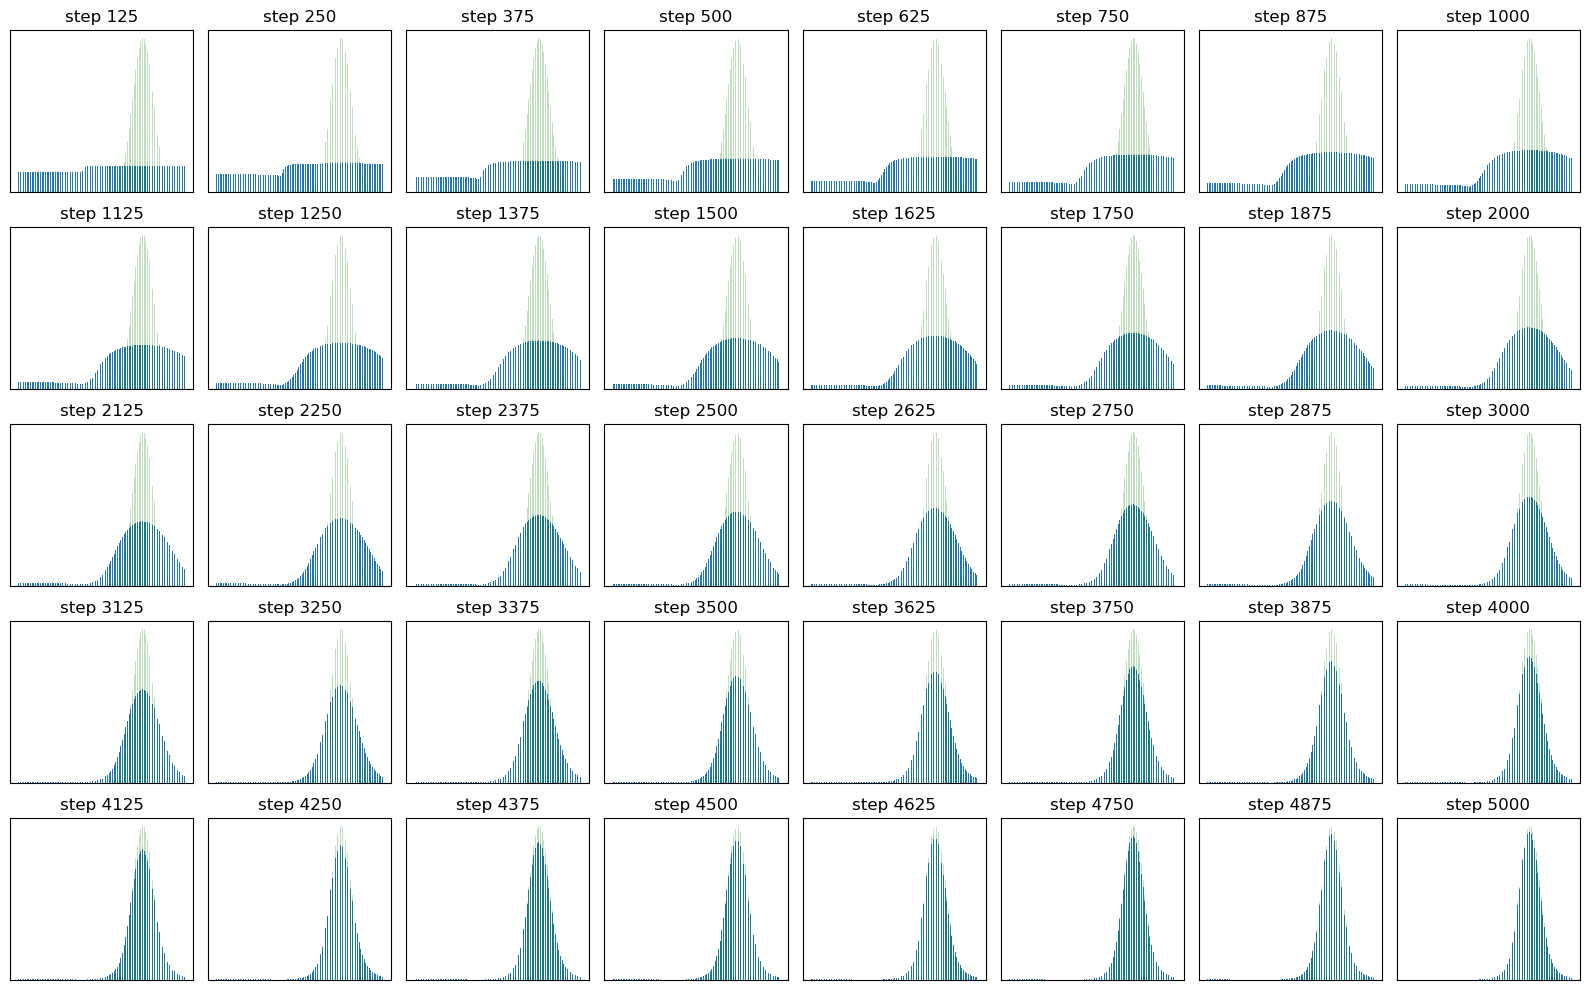

In [15]:
n_steps = 5000
lr = 1e-3
eps_scheduler = Scheduler(eps_default * 0.01, 200, 8.006883e-05, decay_after=3500)
learned, thetas, loss_vals = learn_marginal_logits(mu_true, X, ot_marginal_loss, training_steps=n_steps, lr=lr, scheduler=eps_scheduler)
w2_loss_vals, l2_loss_vals = loss_vals

# plot all thetas

# Create figure and axes grid (5 rows, 8 columns)
fig, axes = plt.subplots(5, 8, figsize=(16, 10))
ax_list = axes.flat
for i, (step, theta) in enumerate(thetas.items()):
    learned_marginal = jax.nn.softmax(theta) 
    ax_list[i].bar(X*80, learned_marginal)
    ax_list[i].bar(X*80, mu_true, color="green", alpha=0.25)
    ax_list[i].set_title(f"step {step}")
    ax_list[i].set_xticks([])
    ax_list[i].set_yticks([])
plt.tight_layout()
plt.show()

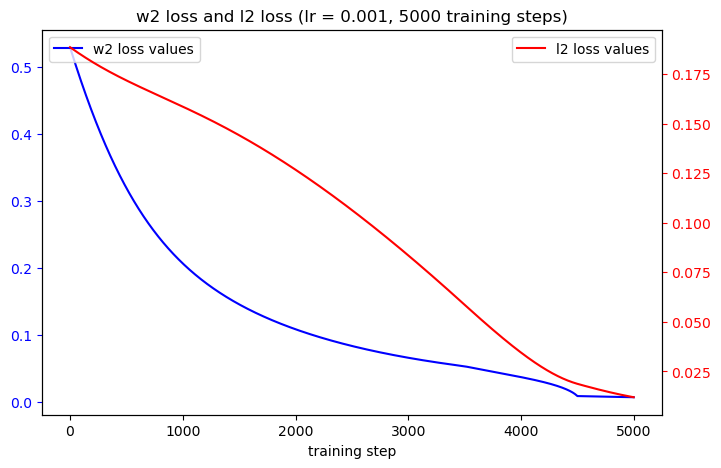

In [ ]:
# Create figure and first y-axis (left)
fig, ax_left = plt.subplots(figsize=(8, 5))
ax_left.plot(list(range(n_steps)), w2_loss_vals, 'b', label='w2 loss values')
#ax_left.set_ylabel("w2 loss value", color='b')
ax_left.tick_params(axis='y', colors='b')

# Create second y-axis (right)
ax_right = ax_left.twinx()  # Mirror y-axis on the right
ax_right.plot(list(range(n_steps)), l2_loss_vals, 'r', label='l2 loss values')  # Red dashed line for cos(x)
#ax_right.set_ylabel("l2 loss value", color='r')
ax_right.tick_params(axis='y', colors='r')

# Set labels and title
ax_left.set_xlabel(f"training step")
plt.title(f"w2 loss and l2 loss (lr = {lr}, {n_steps} training steps)")

# Add legends
ax_left.legend(loc="upper left")
ax_right.legend(loc="upper right")

# Show plot
plt.show()

## Initialize at ground truth
### $\epsilon = 0.125 * \text{eps_default}$ 

In [3]:
# initializing from mu_true logits
n_steps = 20000
lr = 1e-4
learned, thetas, loss_vals = learn_marginal_logits(mu_true, X, ot_marginal_loss,
                                                   epsilon = 0.125 * eps_default,
                                                   training_steps=n_steps, 
                                                   lr=lr, 
                                                   init_from_mu_true=True)
w2_loss_vals, l2_loss_vals = loss_vals

# plot all thetas

# Create figure and axes grid (5 rows, 8 columns)
fig, axes = plt.subplots(5, 8, figsize=(16, 10))
ax_list = axes.flat
for i, (step, theta) in enumerate(thetas.items()):
    learned_marginal = jax.nn.softmax(theta) 
    ax_list[i].bar(80 * X, learned_marginal)
    ax_list[i].bar(80 * X, mu_true, color="green", alpha=0.25)
    ax_list[i].set_title(f"step {step}")
    ax_list[i].set_xticks([])
    ax_list[i].set_yticks([])
plt.tight_layout()
plt.show()

NameError: name 'learn_marginal_logits' is not defined

In [ ]:
# Create figure and first y-axis (left)
fig, ax_left = plt.subplots(figsize=(8, 5))
ax_left.plot(list(range(n_steps)), w2_loss_vals, 'b', label='w2 loss values')
ax_left.set_ylabel("w2 loss value", color='b')
ax_left.tick_params(axis='y', colors='b')

# Create second y-axis (right)
ax_right = ax_left.twinx()  # Mirror y-axis on the right
ax_right.plot(list(range(n_steps)), l2_loss_vals, 'r', label='l2 loss values')  # Red dashed line for cos(x)
ax_right.set_ylabel("l2 loss value", color='r')
ax_right.tick_params(axis='y', colors='r')

# Set labels and title
ax_left.set_xlabel(f"training step")
plt.title(f"w2 loss and l2 loss (lr = {lr}, {n_steps} training steps, initialize at ground truth)")

# Add legends
ax_left.legend(loc="upper left")
ax_right.legend(loc="upper right")

# Show plot
plt.show()

NameError: name 'plt' is not defined

### $\epsilon = 0.01 * \text{eps_default}$

Training Steps: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [04:41<00:00, 71.15step/s]


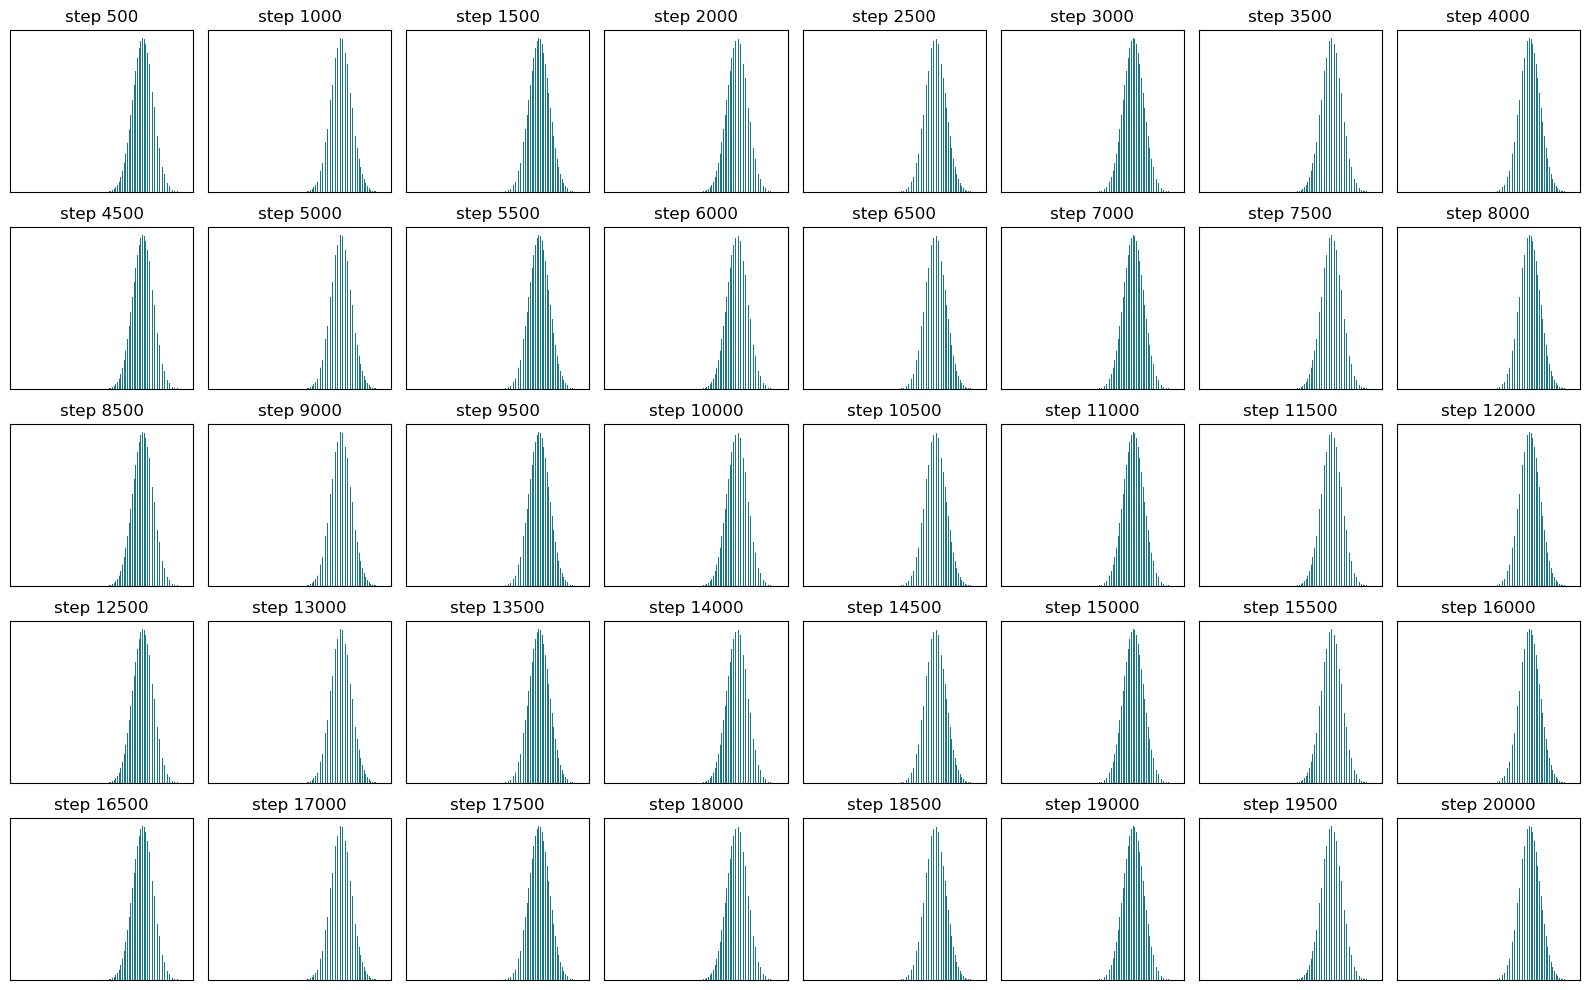

In [ ]:
# initializing from mu_true logits
n_steps = 20000
lr = 1e-4
learned, thetas, loss_vals = learn_marginal_logits(mu_true, X, ot_marginal_loss,
                                                   epsilon = 0.01 * eps_default,
                                                   training_steps=n_steps, 
                                                   lr=lr, 
                                                   init_from_mu_true=True)
w2_loss_vals, l2_loss_vals = loss_vals

# plot all thetas

# Create figure and axes grid (5 rows, 8 columns)
fig, axes = plt.subplots(5, 8, figsize=(16, 10))
ax_list = axes.flat
for i, (step, theta) in enumerate(thetas.items()):
    learned_marginal = jax.nn.softmax(theta) 
    ax_list[i].bar(80 * X, learned_marginal)
    ax_list[i].bar(80 * X, mu_true, color="green", alpha=0.25)
    ax_list[i].set_title(f"step {step}")
    ax_list[i].set_xticks([])
    ax_list[i].set_yticks([])
plt.tight_layout()
plt.show()

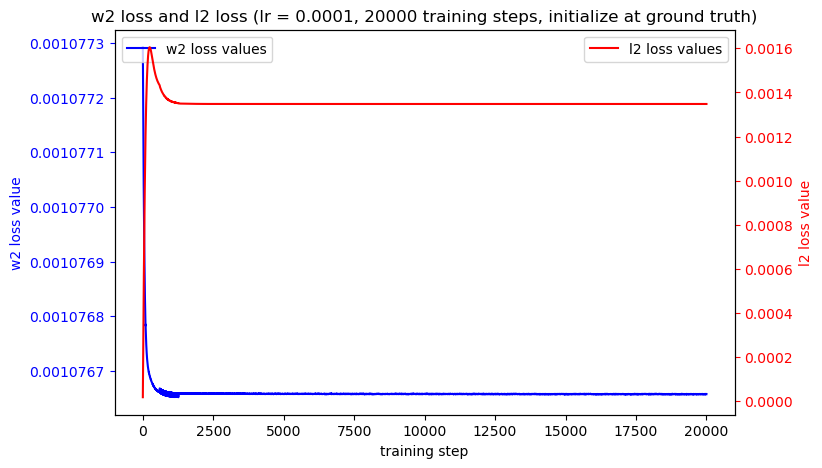

In [ ]:
# Create figure and first y-axis (left)
fig, ax_left = plt.subplots(figsize=(8, 5))
ax_left.plot(list(range(n_steps)), w2_loss_vals, 'b', label='w2 loss values')
ax_left.set_ylabel("w2 loss value", color='b')
ax_left.tick_params(axis='y', colors='b')

# Create second y-axis (right)
ax_right = ax_left.twinx()  # Mirror y-axis on the right
ax_right.plot(list(range(n_steps)), l2_loss_vals, 'r', label='l2 loss values')  # Red dashed line for cos(x)
ax_right.set_ylabel("l2 loss value", color='r')
ax_right.tick_params(axis='y', colors='r')

# Set labels and title
ax_left.set_xlabel(f"training step")
plt.title(f"w2 loss and l2 loss (lr = {lr}, {n_steps} training steps, initialize at ground truth)")

# Add legends
ax_left.legend(loc="upper left")
ax_right.legend(loc="upper right")

# Show plot
plt.show()

## Training without adam optimizer

Training Steps: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [03:27<00:00, 240.73step/s]


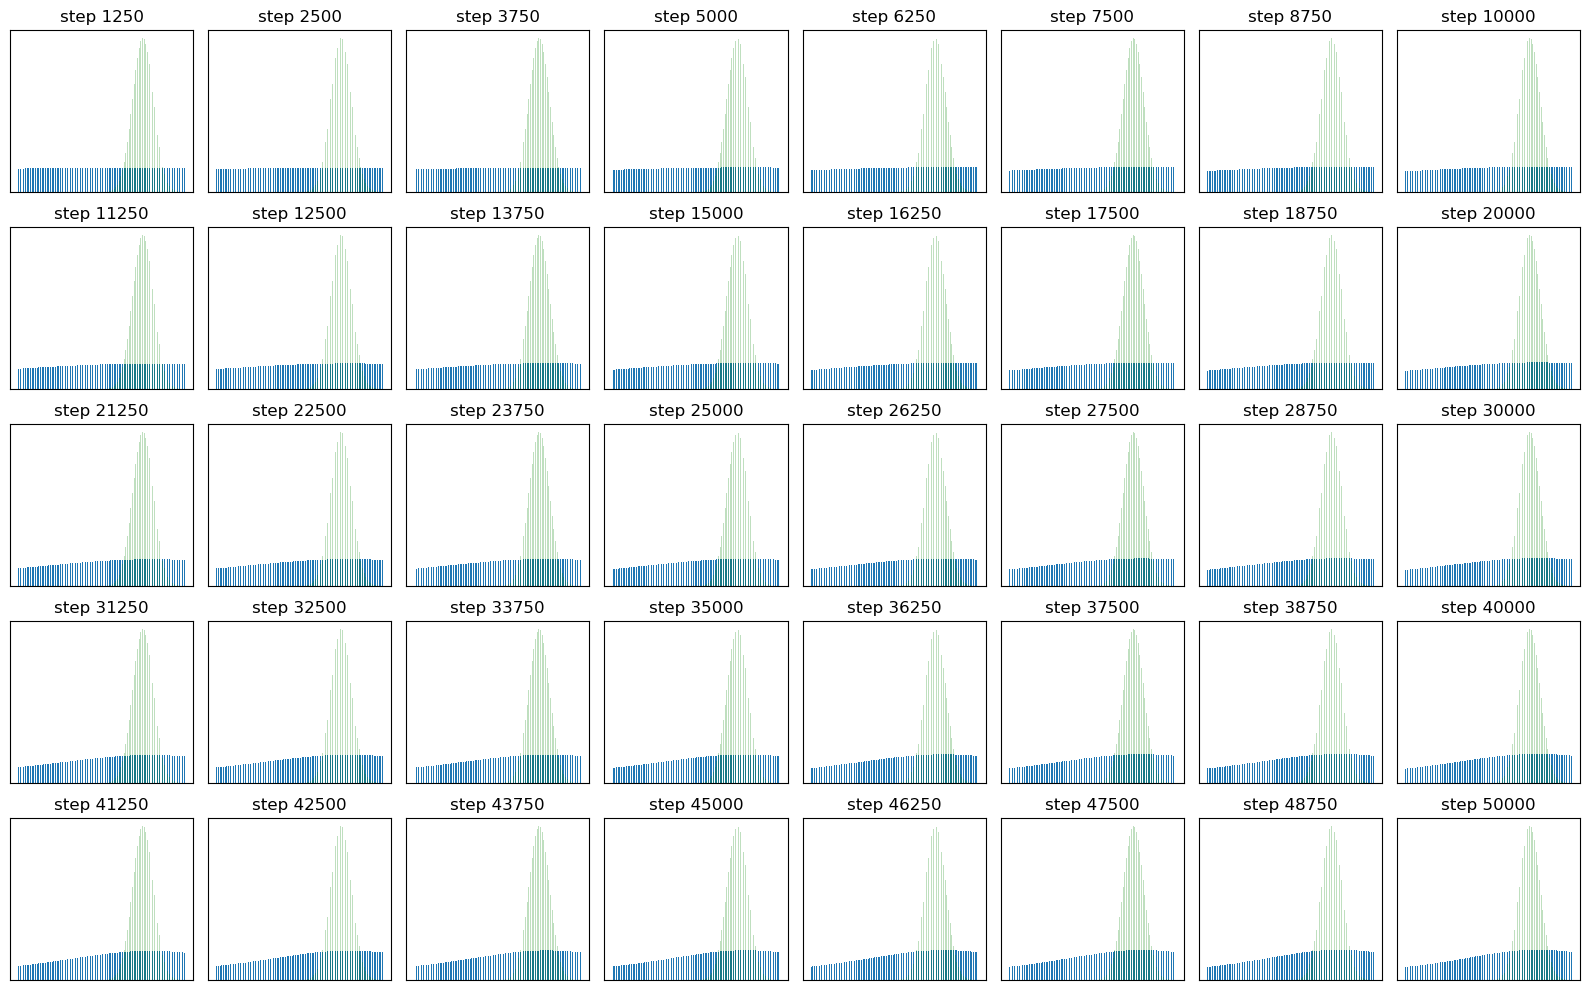

In [191]:
n_steps = 50000
lr = 1e-3
learned, thetas, loss_vals = learn_marginal_logits(mu_true, X, ot_marginal_loss, training_steps=n_steps, epsilon=eps_default, lr=lr, use_adam=False)
w2_loss_vals, l2_loss_vals = loss_vals

# plot all thetas

# Create figure and axes grid (5 rows, 8 columns)
fig, axes = plt.subplots(5, 8, figsize=(16, 10))
ax_list = axes.flat
for i, (step, theta) in enumerate(thetas.items()):
    learned_marginal = jax.nn.softmax(theta) 
    ax_list[i].bar(X*80, learned_marginal)
    ax_list[i].bar(X*80, mu_true, color="green", alpha=0.25)
    ax_list[i].set_title(f"step {step}")
    ax_list[i].set_xticks([])
    ax_list[i].set_yticks([])
plt.tight_layout()
plt.show()

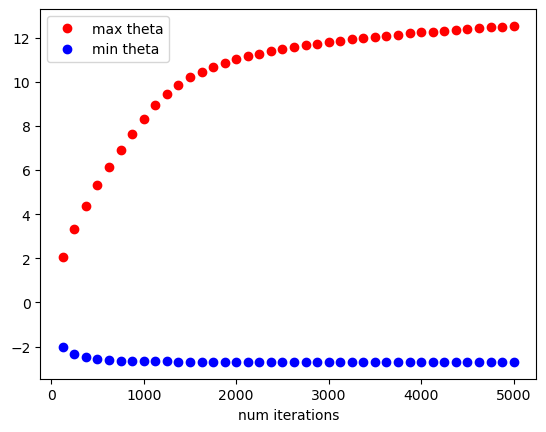

In [105]:
plt.plot(thetas.keys(), [max(theta) for _, theta in thetas.items() ], 'ro', label="max theta")
plt.plot(thetas.keys(), [min(theta) for _, theta in thetas.items() ], 'bo', label="min theta")
plt.xlabel("num iterations")
plt.legend()
plt.show()

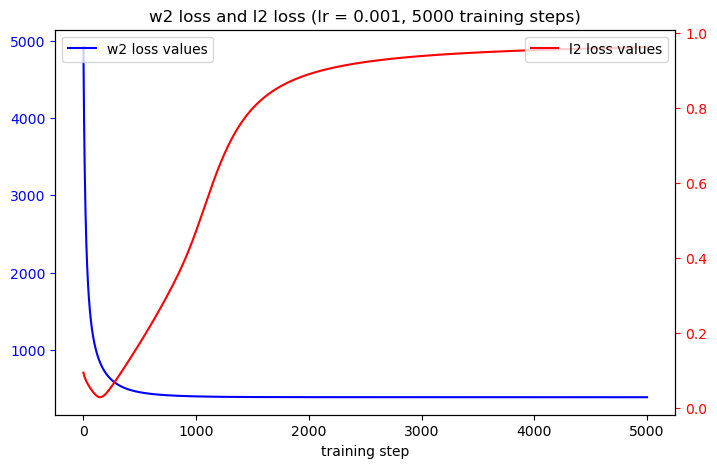

In [106]:
# Create figure and first y-axis (left)
fig, ax_left = plt.subplots(figsize=(8, 5))
ax_left.plot(list(range(n_steps)), w2_loss_vals, 'b', label='w2 loss values')
#ax_left.set_ylabel("w2 loss value", color='b')
ax_left.tick_params(axis='y', colors='b')

# Create second y-axis (right)
ax_right = ax_left.twinx()  # Mirror y-axis on the right
ax_right.plot(list(range(n_steps)), l2_loss_vals, 'r', label='l2 loss values')  # Red dashed line for cos(x)
#ax_right.set_ylabel("l2 loss value", color='r')
ax_right.tick_params(axis='y', colors='r')

# Set labels and title
ax_left.set_xlabel(f"training step")
plt.title(f"w2 loss and l2 loss (lr = {lr}, {n_steps} training steps)")

# Add legends
ax_left.legend(loc="upper left")
ax_right.legend(loc="upper right")

# Show plot
plt.show()

## Train without adam, with stabilization

Training Steps: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:33<00:00, 148.16step/s]


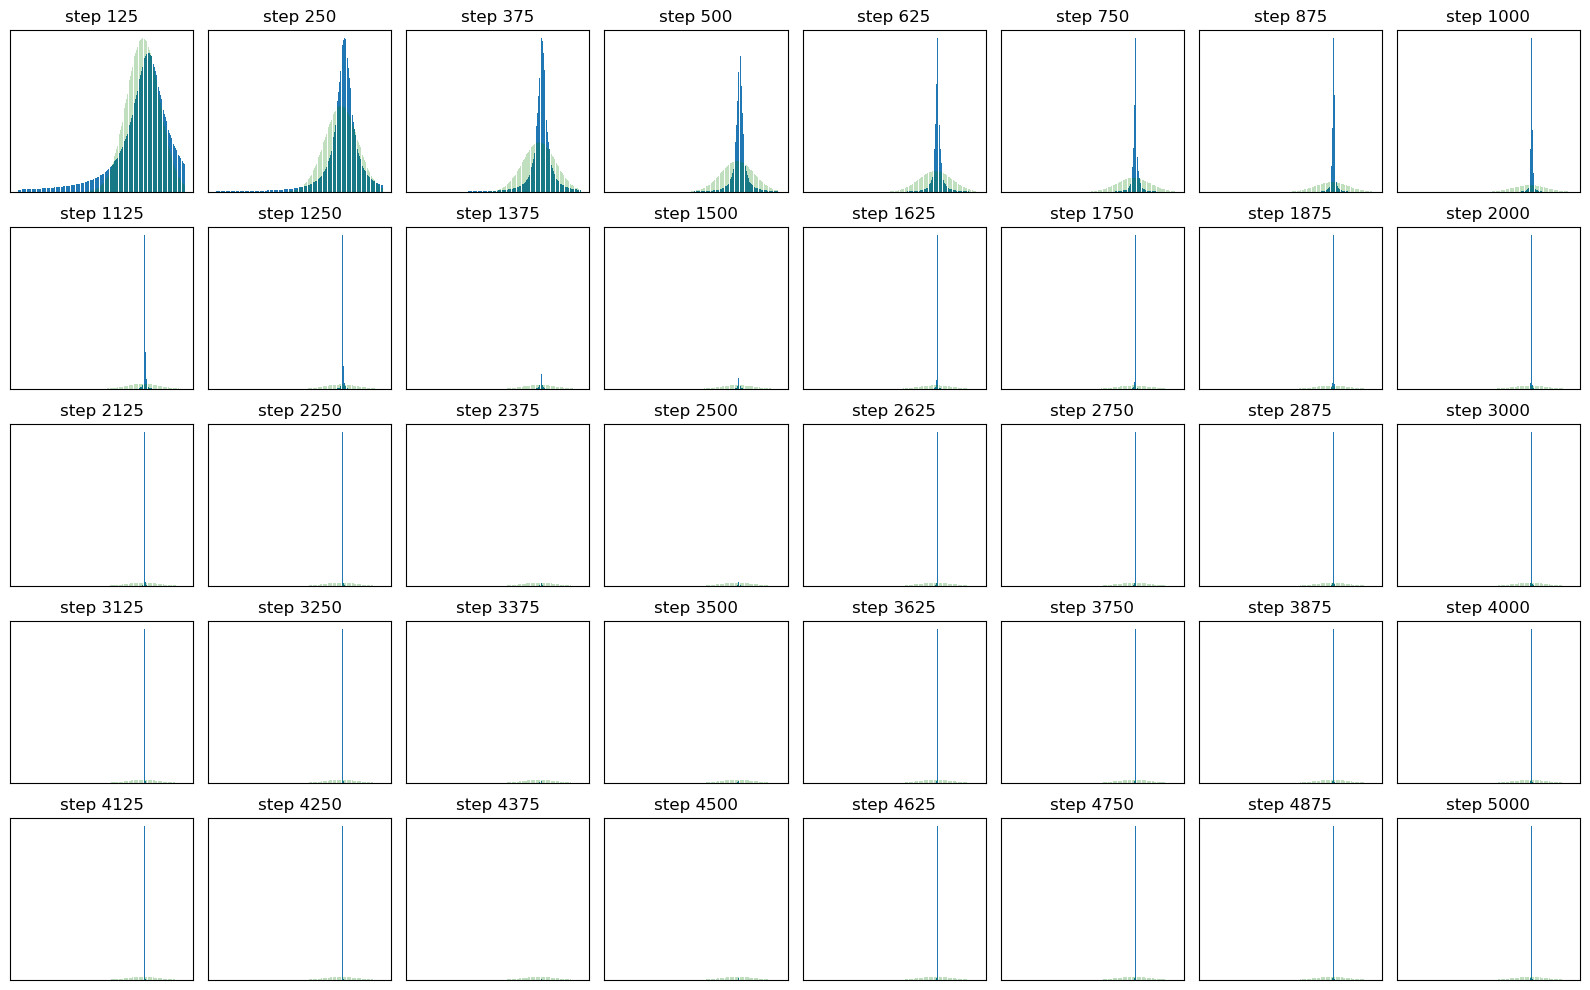

In [133]:
n_steps = 5000
lr = 1e-3
learned, thetas, loss_vals = learn_marginal_logits(mu_true, X, ot_marginal_loss, training_steps=n_steps, epsilon=2*eps_default, lr=lr, use_adam=False, use_stabilization=True)
w2_loss_vals, l2_loss_vals = loss_vals

# plot all thetas

# Create figure and axes grid (5 rows, 8 columns)
fig, axes = plt.subplots(5, 8, figsize=(16, 10))
ax_list = axes.flat
for i, (step, theta) in enumerate(thetas.items()):
    learned_marginal = jax.nn.softmax(theta) 
    ax_list[i].bar(X, learned_marginal)
    ax_list[i].bar(X, mu_true, color="green", alpha=0.25)
    ax_list[i].set_title(f"step {step}")
    ax_list[i].set_xticks([])
    ax_list[i].set_yticks([])
plt.tight_layout()
plt.show()

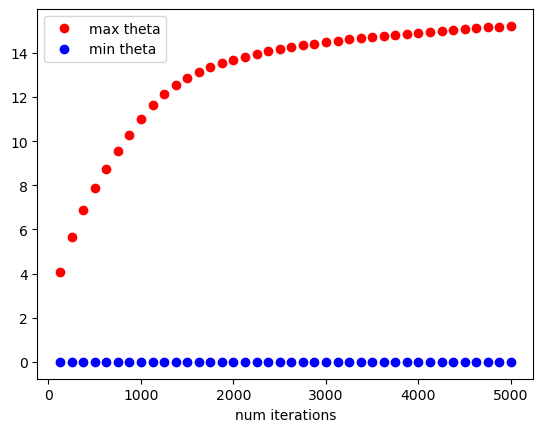

In [134]:
plt.plot(thetas.keys(), [max(theta) for _, theta in thetas.items() ], 'ro', label="max theta")
plt.plot(thetas.keys(), [min(theta) for _, theta in thetas.items() ], 'bo', label="min theta")
plt.xlabel("num iterations")
plt.legend()
plt.show()

## Training with high values of $\epsilon$ 

### $\epsilon = 2 \cdot \text{eps_default}$

Training Steps: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:36<00:00, 543.74step/s]


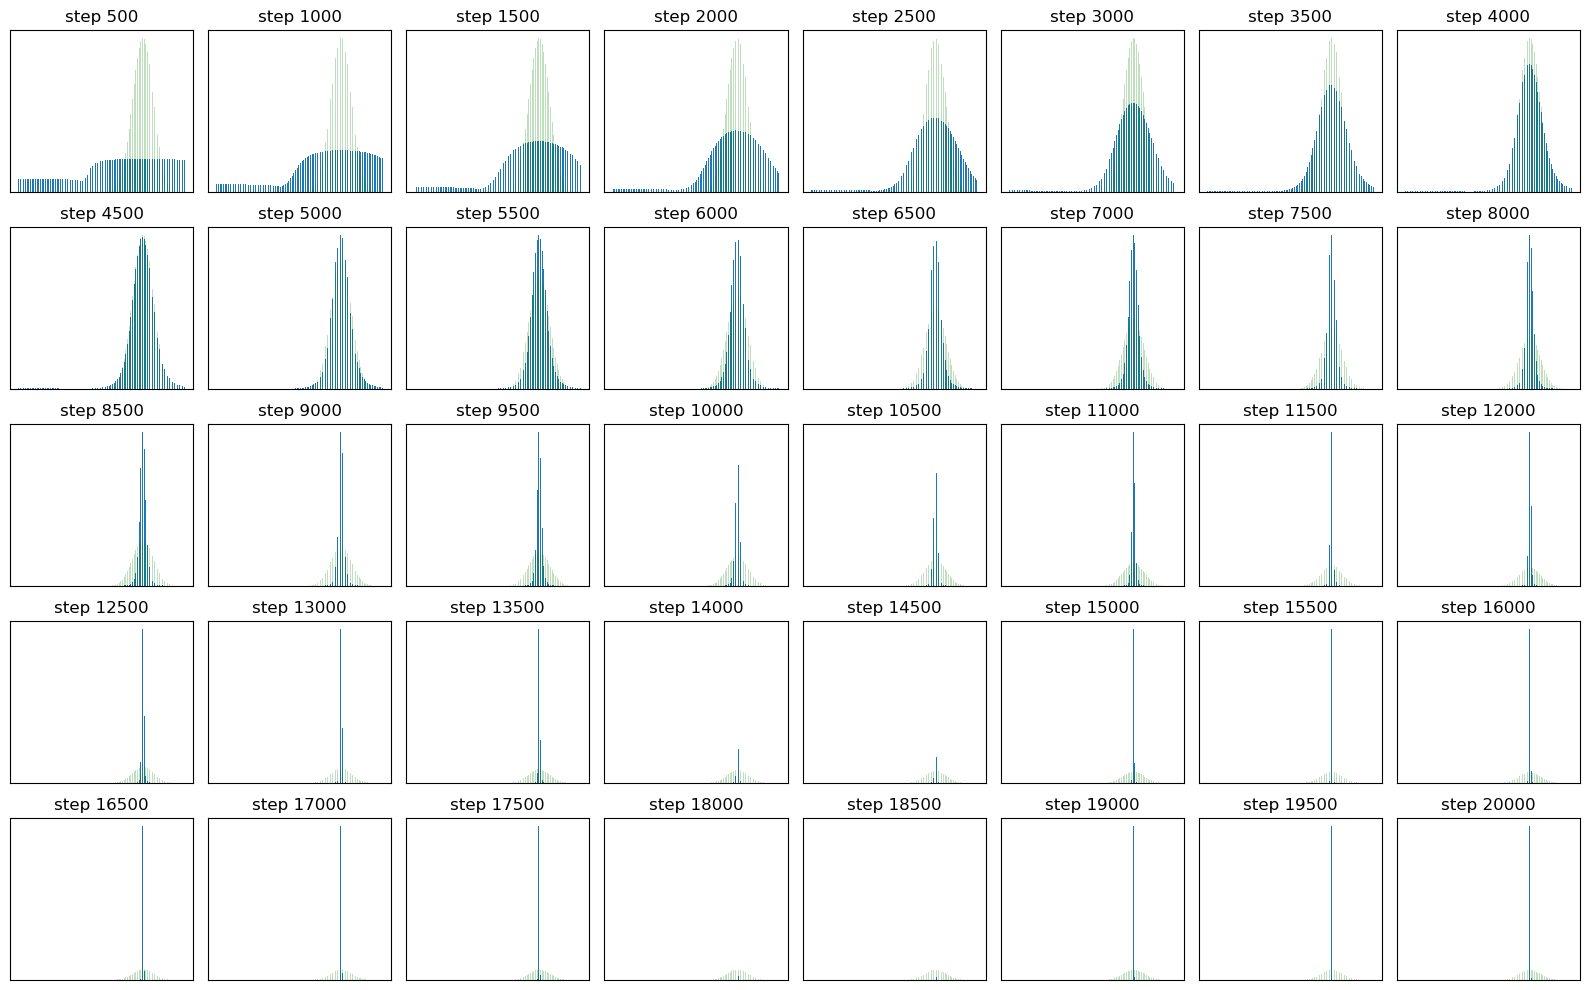

In [259]:
n_steps = 20000
lr = 1e-4
learned, thetas, loss_vals = learn_marginal_logits(mu_true, X, ot_marginal_loss, training_steps=n_steps, epsilon=2*eps_default)
w2_loss_vals, l2_loss_vals = loss_vals

# plot all thetas

# Create figure and axes grid (5 rows, 8 columns)
fig, axes = plt.subplots(5, 8, figsize=(16, 10))
ax_list = axes.flat
for i, (step, theta) in enumerate(thetas.items()):
    learned_marginal = jax.nn.softmax(theta) 
    ax_list[i].bar(80 * X, learned_marginal)
    ax_list[i].bar(80 * X, mu_true, color="green", alpha=0.25)
    ax_list[i].set_title(f"step {step}")
    ax_list[i].set_xticks([])
    ax_list[i].set_yticks([])
plt.tight_layout()
plt.show()

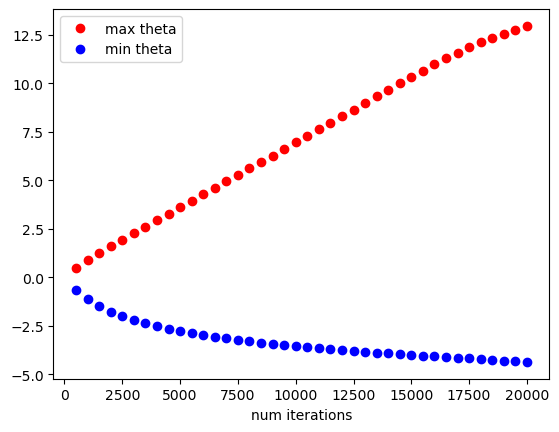

In [69]:
plt.plot(thetas.keys(), [max(theta) for _, theta in thetas.items() ], 'ro', label="max theta")
plt.plot(thetas.keys(), [min(theta) for _, theta in thetas.items() ], 'bo', label="min theta")
plt.xlabel("num iterations")
plt.legend()
plt.show()

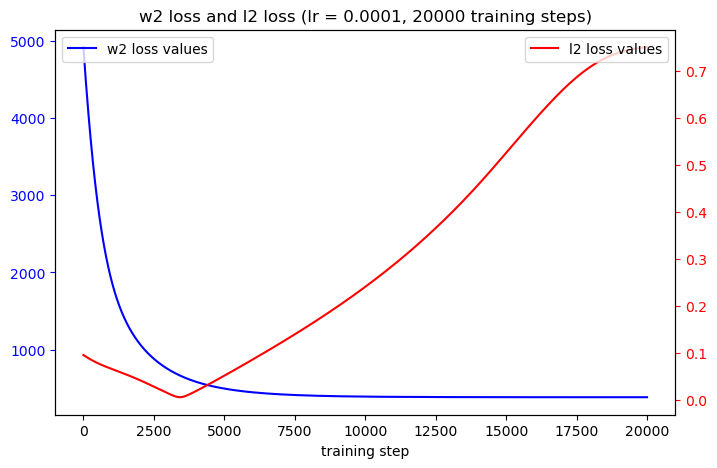

In [70]:
# Create figure and first y-axis (left)
fig, ax_left = plt.subplots(figsize=(8, 5))
ax_left.plot(list(range(n_steps)), w2_loss_vals, 'b', label='w2 loss values')
#ax_left.set_ylabel("w2 loss value", color='b')
ax_left.tick_params(axis='y', colors='b')

# Create second y-axis (right)
ax_right = ax_left.twinx()  # Mirror y-axis on the right
ax_right.plot(list(range(n_steps)), l2_loss_vals, 'r', label='l2 loss values')  # Red dashed line for cos(x)
#ax_right.set_ylabel("l2 loss value", color='r')
ax_right.tick_params(axis='y', colors='r')

# Set labels and title
ax_left.set_xlabel(f"training step")
plt.title(f"w2 loss and l2 loss (lr = {lr}, {n_steps} training steps)")

# Add legends
ax_left.legend(loc="upper left")
ax_right.legend(loc="upper right")

# Show plot
plt.show()

### $\epsilon = 1200$

Training Steps: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [02:05<00:00, 158.92step/s]


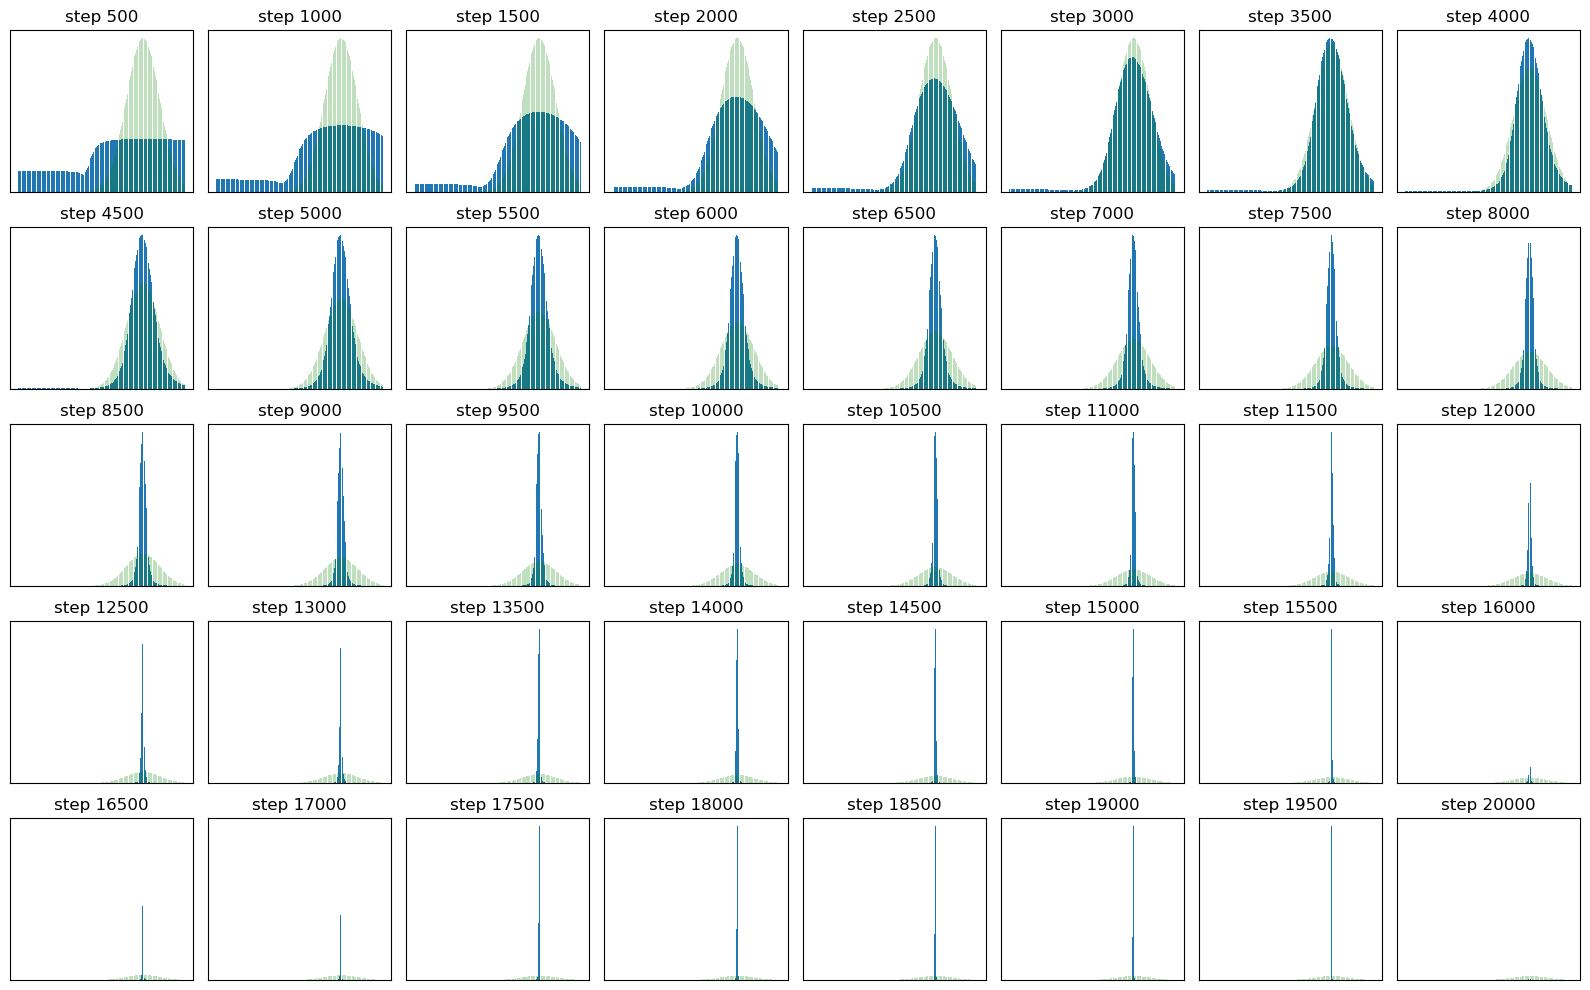

In [83]:
n_steps = 20000
lr = 1e-4
learned, thetas, loss_vals = learn_marginal_logits(mu_true, X, ot_marginal_loss, training_steps=n_steps, epsilon=1200)
w2_loss_vals, l2_loss_vals = loss_vals

# plot all thetas

# Create figure and axes grid (5 rows, 8 columns)
fig, axes = plt.subplots(5, 8, figsize=(16, 10))
ax_list = axes.flat
for i, (step, theta) in enumerate(thetas.items()):
    learned_marginal = jax.nn.softmax(theta) 
    ax_list[i].bar(X, learned_marginal)
    ax_list[i].bar(X, mu_true, color="green", alpha=0.25)
    ax_list[i].set_title(f"step {step}")
    ax_list[i].set_xticks([])
    ax_list[i].set_yticks([])
plt.tight_layout()
plt.show()

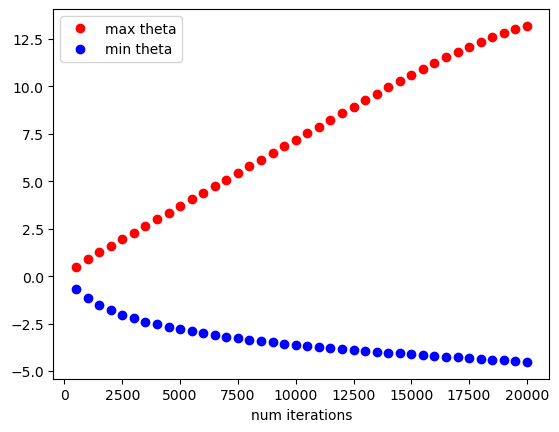

In [84]:
plt.plot(thetas.keys(), [max(theta) for _, theta in thetas.items() ], 'ro', label="max theta")
plt.plot(thetas.keys(), [min(theta) for _, theta in thetas.items() ], 'bo', label="min theta")
plt.xlabel("num iterations")
plt.legend()
plt.show()

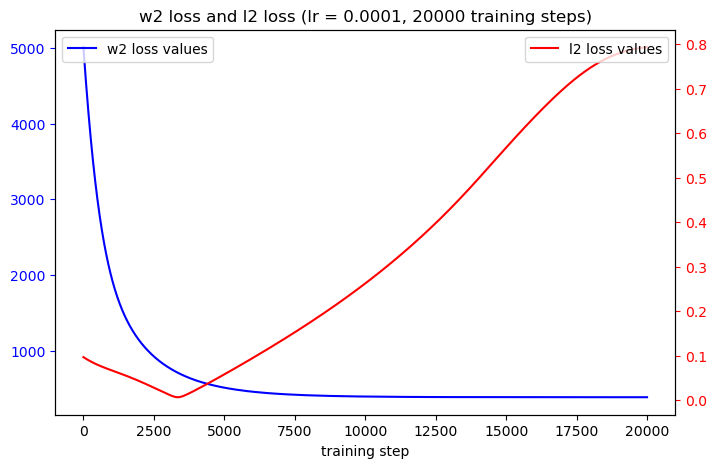

In [85]:
# Create figure and first y-axis (left)
fig, ax_left = plt.subplots(figsize=(8, 5))
ax_left.plot(list(range(n_steps)), w2_loss_vals, 'b', label='w2 loss values')
#ax_left.set_ylabel("w2 loss value", color='b')
ax_left.tick_params(axis='y', colors='b')

# Create second y-axis (right)
ax_right = ax_left.twinx()  # Mirror y-axis on the right
ax_right.plot(list(range(n_steps)), l2_loss_vals, 'r', label='l2 loss values')  # Red dashed line for cos(x)
#ax_right.set_ylabel("l2 loss value", color='r')
ax_right.tick_params(axis='y', colors='r')

# Set labels and title
ax_left.set_xlabel(f"training step")
plt.title(f"w2 loss and l2 loss (lr = {lr}, {n_steps} training steps)")

# Add legends
ax_left.legend(loc="upper left")
ax_right.legend(loc="upper right")

# Show plot
plt.show()

### $\epsilon = 1500$

Training Steps: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 40000/40000 [04:23<00:00, 151.95step/s]


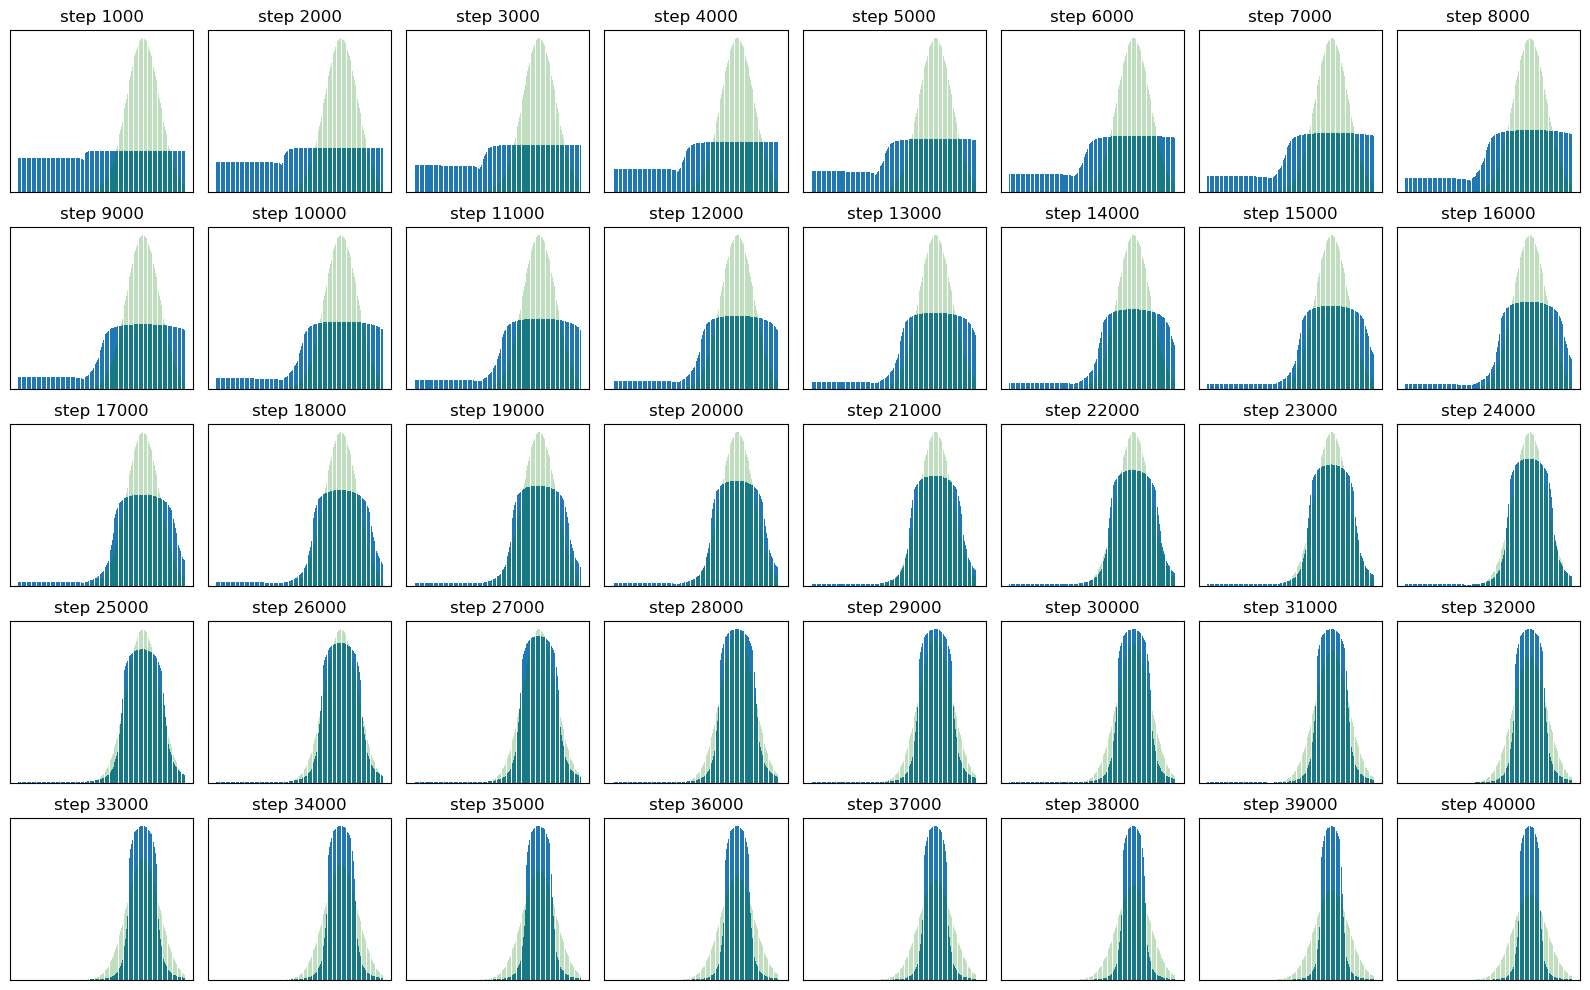

In [77]:
n_steps = 40000
lr = 1e-4
learned, thetas, loss_vals = learn_marginal_logits(mu_true, X, ot_marginal_loss, training_steps=n_steps, lr=lr, tau=1.0, epsilon=1500)
w2_loss_vals, l2_loss_vals = loss_vals

# plot all thetas

# Create figure and axes grid (5 rows, 8 columns)
fig, axes = plt.subplots(5, 8, figsize=(16, 10))
ax_list = axes.flat
for i, (step, theta) in enumerate(thetas.items()):
    learned_marginal = jax.nn.softmax(theta) 
    ax_list[i].bar(X, learned_marginal)
    ax_list[i].bar(X, mu_true, color="green", alpha=0.25)
    ax_list[i].set_title(f"step {step}")
    ax_list[i].set_xticks([])
    ax_list[i].set_yticks([])
plt.tight_layout()
plt.show()

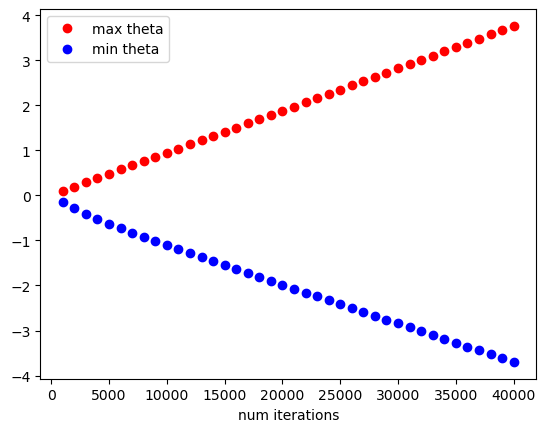

In [80]:
plt.plot(thetas.keys(), [max(theta) for _, theta in thetas.items() ], 'ro', label="max theta")
plt.plot(thetas.keys(), [min(theta) for _, theta in thetas.items() ], 'bo', label="min theta")
plt.xlabel("num iterations")
plt.legend()
plt.show()

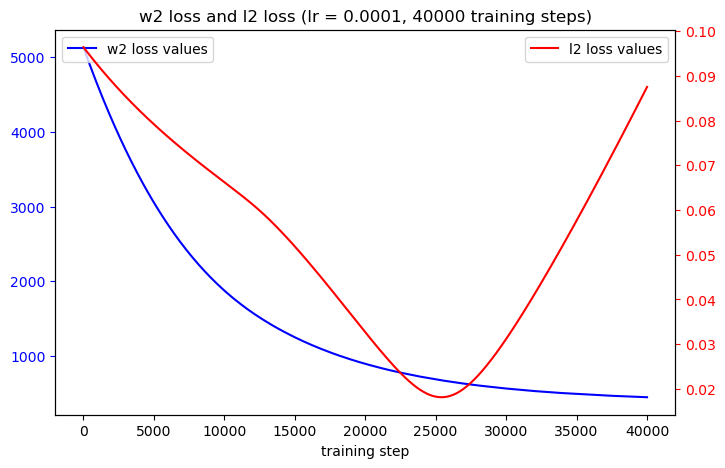

In [81]:
# Create figure and first y-axis (left)
fig, ax_left = plt.subplots(figsize=(8, 5))
ax_left.plot(list(range(n_steps)), w2_loss_vals, 'b', label='w2 loss values')
#ax_left.set_ylabel("w2 loss value", color='b')
ax_left.tick_params(axis='y', colors='b')

# Create second y-axis (right)
ax_right = ax_left.twinx()  # Mirror y-axis on the right
ax_right.plot(list(range(n_steps)), l2_loss_vals, 'r', label='l2 loss values')  # Red dashed line for cos(x)
#ax_right.set_ylabel("l2 loss value", color='r')
ax_right.tick_params(axis='y', colors='r')

# Set labels and title
ax_left.set_xlabel(f"training step")
plt.title(f"w2 loss and l2 loss (lr = {lr}, {n_steps} training steps)")

# Add legends
ax_left.legend(loc="upper left")
ax_right.legend(loc="upper right")

# Show plot
plt.show()

## Initialize from ground truth
### Use $\epsilon = 0.125 * \text{eps_default}$

Training Steps: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:59<00:00, 335.04step/s]


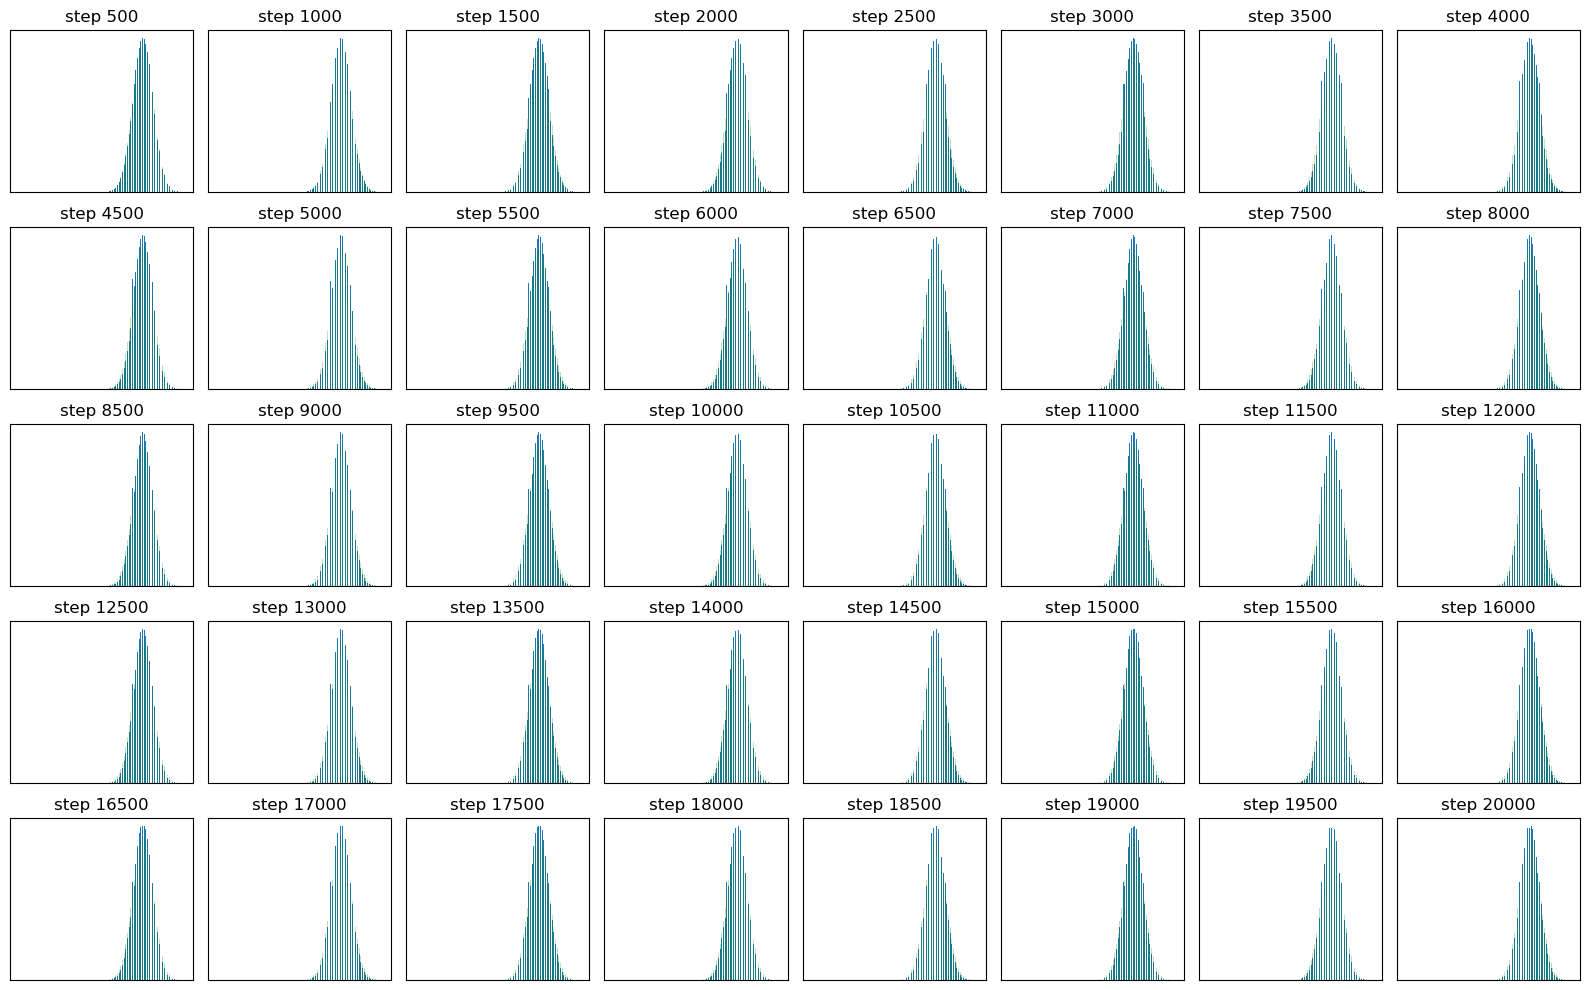

In [197]:
# initializing from mu_true logits
n_steps = 20000
lr = 1e-4
learned, thetas, loss_vals = learn_marginal_logits(mu_true, X, ot_marginal_loss,
                                                   epsilon = 0.125 * eps_default,
                                                   training_steps=n_steps, 
                                                   lr=lr, 
                                                   init_from_mu_true=True)
w2_loss_vals, l2_loss_vals = loss_vals

# plot all thetas

# Create figure and axes grid (5 rows, 8 columns)
fig, axes = plt.subplots(5, 8, figsize=(16, 10))
ax_list = axes.flat
for i, (step, theta) in enumerate(thetas.items()):
    learned_marginal = jax.nn.softmax(theta) 
    ax_list[i].bar(80 * X, learned_marginal)
    ax_list[i].bar(80 * X, mu_true, color="green", alpha=0.25)
    ax_list[i].set_title(f"step {step}")
    ax_list[i].set_xticks([])
    ax_list[i].set_yticks([])
plt.tight_layout()
plt.show()

In [ ]:
# Create figure and first y-axis (left)
fig, ax_left = plt.subplots(figsize=(8, 5))
ax_left.plot(list(range(n_steps)), w2_loss_vals, 'b', label='w2 loss values')
ax_left.set_ylabel("w2 loss value", color='b')
ax_left.tick_params(axis='y', colors='b')

# Create second y-axis (right)
ax_right = ax_left.twinx()  # Mirror y-axis on the right
ax_right.plot(list(range(n_steps)), l2_loss_vals, 'r', label='l2 loss values')  # Red dashed line for cos(x)
ax_right.set_ylabel("l2 loss value", color='r')
ax_right.tick_params(axis='y', colors='r')

# Set labels and title
ax_left.set_xlabel(f"training step")
plt.title(f"w2 loss and l2 loss (lr = {lr}, {n_steps} training steps, initialize at ground truth)")

# Add legends
ax_left.legend(loc="upper left")
ax_right.legend(loc="upper right")

# Show plot
plt.show()

## Use $\epsilon = 0.01 * \text{eps_default}$

Training Steps: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [04:49<00:00, 69.11step/s]


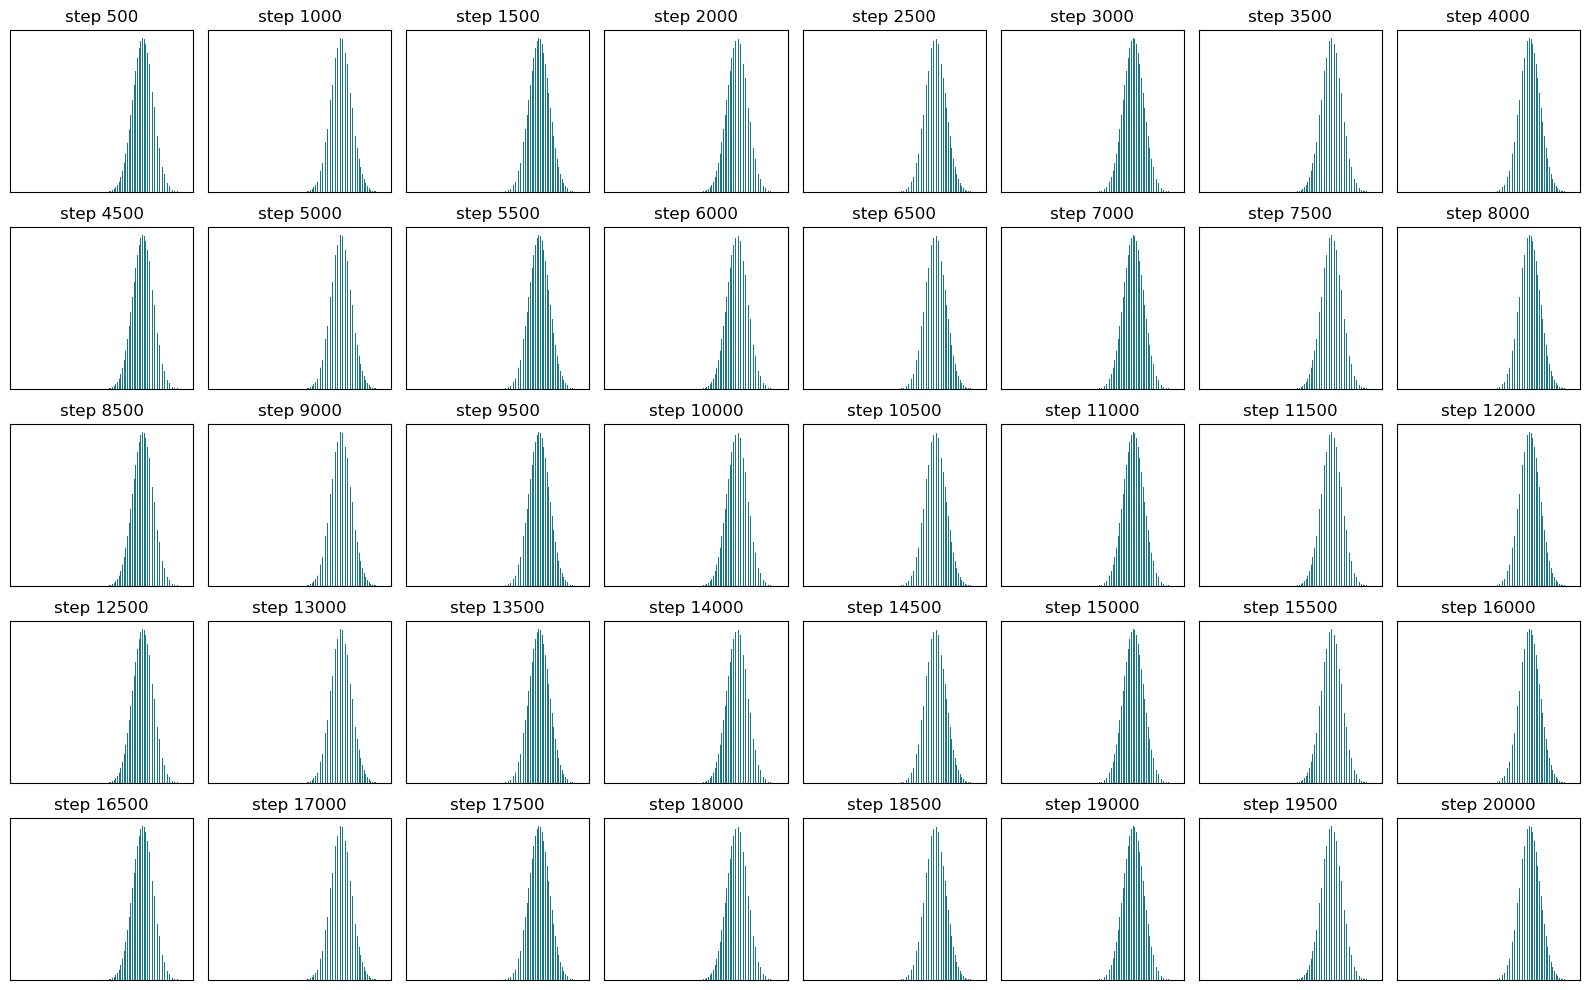

In [200]:
# initializing from mu_true logits
n_steps = 5000
lr = 1e-4
learned, thetas, loss_vals = learn_marginal_logits(mu_true, X, ot_marginal_loss,
                                                   epsilon = 0.01 * eps_default,
                                                   training_steps=n_steps, 
                                                   lr=lr, 
                                                   init_from_mu_true=True)
w2_loss_vals, l2_loss_vals = loss_vals

# plot all thetas

# Create figure and axes grid (5 rows, 8 columns)
fig, axes = plt.subplots(5, 8, figsize=(16, 10))
ax_list = axes.flat
for i, (step, theta) in enumerate(thetas.items()):
    learned_marginal = jax.nn.softmax(theta) 
    ax_list[i].bar(80 * X, learned_marginal)
    ax_list[i].bar(80 * X, mu_true, color="green", alpha=0.25)
    ax_list[i].set_title(f"step {step}")
    ax_list[i].set_xticks([])
    ax_list[i].set_yticks([])
plt.tight_layout()
plt.show()

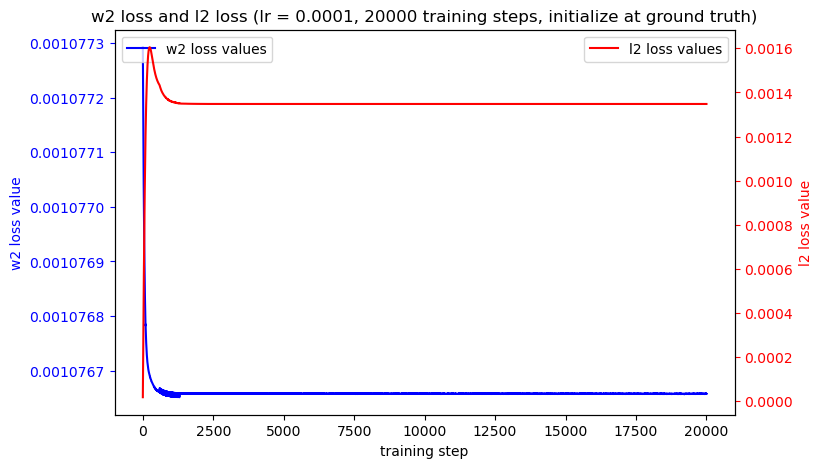

In [201]:
# Create figure and first y-axis (left)
fig, ax_left = plt.subplots(figsize=(8, 5))
ax_left.plot(list(range(n_steps)), w2_loss_vals, 'b', label='w2 loss values')
ax_left.set_ylabel("w2 loss value", color='b')
ax_left.tick_params(axis='y', colors='b')

# Create second y-axis (right)
ax_right = ax_left.twinx()  # Mirror y-axis on the right
ax_right.plot(list(range(n_steps)), l2_loss_vals, 'r', label='l2 loss values')  # Red dashed line for cos(x)
ax_right.set_ylabel("l2 loss value", color='r')
ax_right.tick_params(axis='y', colors='r')

# Set labels and title
ax_left.set_xlabel(f"training step")
plt.title(f"w2 loss and l2 loss (lr = {lr}, {n_steps} training steps, initialize at ground truth)")

# Add legends
ax_left.legend(loc="upper left")
ax_right.legend(loc="upper right")

# Show plot
plt.show()

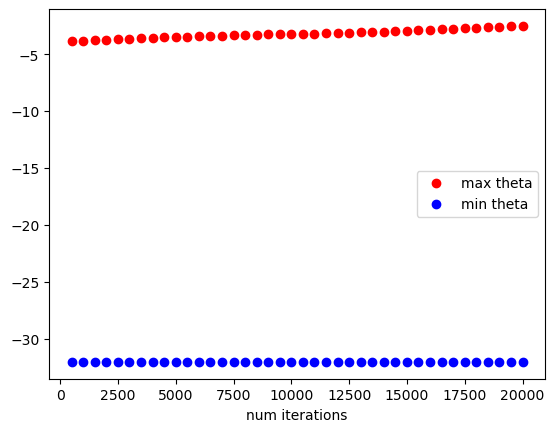

In [87]:
plt.plot(thetas.keys(), [max(theta) for _, theta in thetas.items() ], 'ro', label="max theta")
plt.plot(thetas.keys(), [min(theta) for _, theta in thetas.items() ], 'bo', label="min theta")
plt.xlabel("num iterations")
plt.legend()
plt.show()

## Compute $W_2$ loss between optimum and itself for varying $\epsilon$

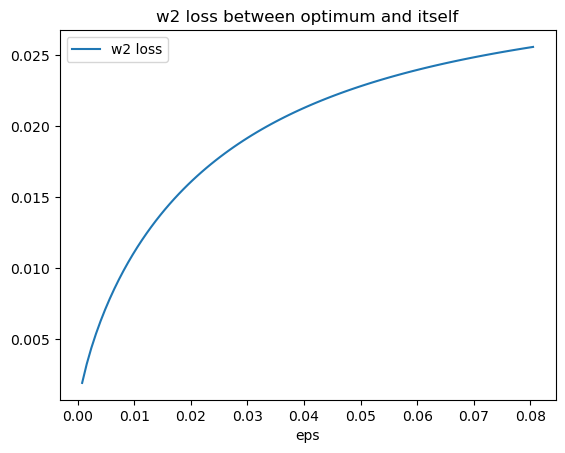

In [285]:
eps_arr = jnp.linspace(0, 2*eps_default, 100)
tau = 1.0
w2_losses = [ot_marginal_loss(mu_true, mu_true, X_reshaped, eps, tau) for eps in eps_arr]
plt.plot(eps_arr, w2_losses, label='w2 loss')
plt.xlabel('eps')
plt.legend()
plt.title("w2 loss between optimum and itself")
plt.show()

In [405]:
X_reshaped = X.reshape((X.shape[0], 1)).astype(jnp.float64)
print(ot_marginal_loss(mu_true, mu_true, X_reshaped, epsilon=1e-4)) # close to 0
print(ot_marginal_loss(mu_true, mu_true, X_reshaped, epsilon=None))

0.00043879777415227407
354.7591970875212


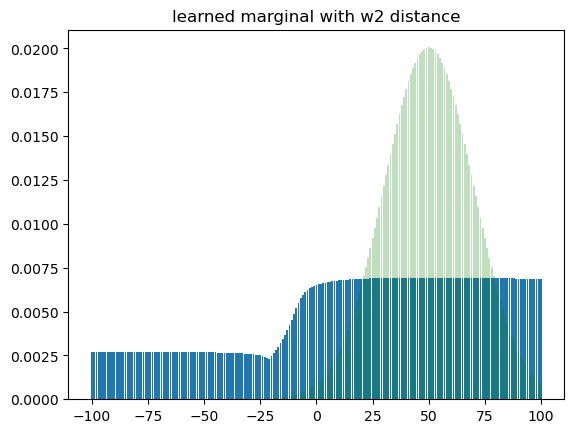

In [7]:
learned_mu_true = jax.nn.softmax(learned)
plt.bar(X, learned_mu_true, label="learned marginal")
plt.bar(X, mu_true, label="ground truth", color="green", alpha=0.25)
plt.title(f"learned marginal with w2 distance")
plt.show()

Training Steps:   0%|▎                                                                                              | 16/5000 [00:01<05:10, 16.06step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


Training Steps:   1%|▊                                                                                              | 43/5000 [00:01<01:46, 46.50step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


Training Steps:   1%|█▎                                                                                             | 70/5000 [00:01<01:05, 74.72step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


Training Steps:   2%|█▊                                                                                             | 98/5000 [00:01<00:49, 99.54step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


Training Steps:   3%|██▎                                                                                          | 126/5000 [00:02<00:42, 115.50step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


Training Steps:   3%|██▊                                                                                          | 154/5000 [00:02<00:39, 123.82step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


Training Steps:   4%|███▍                                                                                         | 182/5000 [00:02<00:37, 128.71step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


Training Steps:   4%|███▉                                                                                         | 210/5000 [00:02<00:36, 130.83step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


Training Steps:   5%|████▍                                                                                        | 238/5000 [00:03<00:36, 131.53step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


Training Steps:   5%|████▉                                                                                        | 266/5000 [00:03<00:36, 131.02step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


Training Steps:   6%|█████▍                                                                                       | 294/5000 [00:03<00:35, 132.63step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


Training Steps:   6%|█████▉                                                                                       | 322/5000 [00:03<00:35, 132.63step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


Training Steps:   7%|██████▌                                                                                      | 350/5000 [00:03<00:35, 132.17step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


Training Steps:   8%|███████                                                                                      | 378/5000 [00:04<00:34, 132.59step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


Training Steps:   8%|███████▌                                                                                     | 406/5000 [00:04<00:34, 133.05step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


Training Steps:   9%|████████                                                                                     | 434/5000 [00:04<00:34, 132.77step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan



Training Steps:   9%|████████▎                                                                                    | 448/5000 [00:04<00:34, 133.11step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


Training Steps:  10%|████████▊                                                                                    | 476/5000 [00:04<00:34, 131.70step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


Training Steps:  10%|█████████▎                                                                                   | 504/5000 [00:05<00:33, 132.40step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


Training Steps:  11%|█████████▉                                                                                   | 532/5000 [00:05<00:33, 132.30step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


Training Steps:  11%|██████████▍                                                                                  | 560/5000 [00:05<00:33, 132.90step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


Training Steps:  12%|██████████▉                                                                                  | 588/5000 [00:05<00:33, 132.31step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


Training Steps:  12%|███████████▍                                                                                 | 616/5000 [00:05<00:34, 128.28step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


Training Steps:  13%|███████████▉                                                                                 | 644/5000 [00:06<00:33, 130.51step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


Training Steps:  13%|████████████▍                                                                                | 672/5000 [00:06<00:32, 131.45step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


Training Steps:  14%|█████████████                                                                                | 700/5000 [00:06<00:32, 132.04step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan



Training Steps:  14%|█████████████▎                                                                               | 714/5000 [00:06<00:32, 132.23step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


Training Steps:  15%|█████████████▊                                                                               | 741/5000 [00:06<00:34, 122.03step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


Training Steps:  15%|██████████████▎                                                                              | 767/5000 [00:07<00:33, 125.33step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


Training Steps:  16%|██████████████▊                                                                              | 795/5000 [00:07<00:32, 129.04step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


Training Steps:  16%|███████████████▎                                                                             | 823/5000 [00:07<00:31, 131.46step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


Training Steps:  17%|███████████████▊                                                                             | 851/5000 [00:07<00:31, 132.31step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


Training Steps:  18%|████████████████▎                                                                            | 879/5000 [00:07<00:31, 131.66step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


Training Steps:  18%|████████████████▊                                                                            | 907/5000 [00:08<00:30, 132.37step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


Training Steps:  19%|█████████████████▍                                                                           | 935/5000 [00:08<00:30, 132.93step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


Training Steps:  19%|█████████████████▉                                                                           | 963/5000 [00:08<00:30, 133.23step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


Training Steps:  20%|██████████████████▍                                                                          | 991/5000 [00:08<00:30, 133.43step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


Training Steps:  20%|██████████████████▋                                                                         | 1019/5000 [00:08<00:29, 133.45step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


Training Steps:  21%|███████████████████▎                                                                        | 1047/5000 [00:09<00:29, 133.61step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


Training Steps:  22%|███████████████████▊                                                                        | 1075/5000 [00:09<00:29, 132.85step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan



Training Steps:  22%|████████████████████                                                                        | 1089/5000 [00:09<00:30, 127.55step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


Training Steps:  22%|████████████████████▌                                                                       | 1116/5000 [00:09<00:30, 128.72step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


Training Steps:  23%|█████████████████████                                                                       | 1144/5000 [00:09<00:29, 131.45step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


Training Steps:  23%|█████████████████████▌                                                                      | 1172/5000 [00:10<00:28, 132.72step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


Training Steps:  24%|██████████████████████                                                                      | 1200/5000 [00:10<00:28, 133.61step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


Training Steps:  25%|██████████████████████▌                                                                     | 1228/5000 [00:10<00:28, 134.08step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


Training Steps:  25%|███████████████████████                                                                     | 1256/5000 [00:10<00:28, 133.18step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


Training Steps:  26%|███████████████████████▋                                                                    | 1284/5000 [00:10<00:28, 131.59step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


Training Steps:  26%|████████████████████████▏                                                                   | 1312/5000 [00:11<00:28, 130.65step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


Training Steps:  27%|████████████████████████▋                                                                   | 1340/5000 [00:11<00:28, 127.24step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


Training Steps:  27%|█████████████████████████▏                                                                  | 1368/5000 [00:11<00:27, 129.90step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


Training Steps:  28%|█████████████████████████▋                                                                  | 1396/5000 [00:11<00:27, 130.00step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


Training Steps:  28%|██████████████████████████▏                                                                 | 1424/5000 [00:12<00:27, 131.43step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


Training Steps:  29%|██████████████████████████▋                                                                 | 1452/5000 [00:12<00:27, 130.95step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan



Training Steps:  29%|██████████████████████████▉                                                                 | 1466/5000 [00:12<00:26, 131.32step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


Training Steps:  30%|███████████████████████████▍                                                                | 1494/5000 [00:12<00:26, 131.51step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


Training Steps:  30%|████████████████████████████                                                                | 1522/5000 [00:12<00:26, 132.44step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


Training Steps:  31%|████████████████████████████▌                                                               | 1550/5000 [00:13<00:26, 131.18step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


Training Steps:  32%|█████████████████████████████                                                               | 1578/5000 [00:13<00:25, 131.97step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


Training Steps:  32%|█████████████████████████████▌                                                              | 1606/5000 [00:13<00:26, 127.66step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


Training Steps:  33%|██████████████████████████████                                                              | 1633/5000 [00:13<00:26, 129.04step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


Training Steps:  33%|██████████████████████████████▌                                                             | 1660/5000 [00:13<00:25, 128.68step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


Training Steps:  34%|███████████████████████████████                                                             | 1688/5000 [00:14<00:25, 130.88step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


Training Steps:  34%|███████████████████████████████▌                                                            | 1716/5000 [00:14<00:24, 131.74step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


Training Steps:  35%|████████████████████████████████                                                            | 1744/5000 [00:14<00:24, 132.47step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


Training Steps:  35%|████████████████████████████████▌                                                           | 1772/5000 [00:14<00:24, 133.34step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


Training Steps:  36%|█████████████████████████████████                                                           | 1800/5000 [00:14<00:24, 133.07step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan



Training Steps:  36%|█████████████████████████████████▍                                                          | 1814/5000 [00:15<00:24, 132.63step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


Training Steps:  37%|█████████████████████████████████▉                                                          | 1842/5000 [00:15<00:23, 132.87step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


Training Steps:  37%|██████████████████████████████████▍                                                         | 1870/5000 [00:15<00:23, 133.09step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


Training Steps:  38%|██████████████████████████████████▉                                                         | 1898/5000 [00:15<00:23, 131.93step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


Training Steps:  39%|███████████████████████████████████▍                                                        | 1926/5000 [00:15<00:23, 132.64step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


Training Steps:  39%|███████████████████████████████████▉                                                        | 1954/5000 [00:16<00:23, 131.92step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


Training Steps:  40%|████████████████████████████████████▍                                                       | 1982/5000 [00:16<00:22, 131.70step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


Training Steps:  40%|████████████████████████████████████▉                                                       | 2010/5000 [00:16<00:22, 131.60step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


Training Steps:  41%|█████████████████████████████████████▍                                                      | 2038/5000 [00:16<00:22, 131.78step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


Training Steps:  41%|██████████████████████████████████████                                                      | 2066/5000 [00:16<00:22, 130.09step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


Training Steps:  42%|██████████████████████████████████████▌                                                     | 2094/5000 [00:17<00:22, 130.57step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


Training Steps:  42%|███████████████████████████████████████                                                     | 2122/5000 [00:17<00:22, 130.19step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


Training Steps:  43%|███████████████████████████████████████▌                                                    | 2150/5000 [00:17<00:21, 131.44step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan



Training Steps:  43%|███████████████████████████████████████▊                                                    | 2164/5000 [00:17<00:21, 131.06step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


Training Steps:  44%|████████████████████████████████████████▎                                                   | 2192/5000 [00:17<00:21, 131.22step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


Training Steps:  44%|████████████████████████████████████████▊                                                   | 2220/5000 [00:18<00:21, 130.20step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


Training Steps:  45%|█████████████████████████████████████████▎                                                  | 2248/5000 [00:18<00:20, 131.05step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


Training Steps:  46%|█████████████████████████████████████████▉                                                  | 2276/5000 [00:18<00:20, 129.74step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


Training Steps:  46%|██████████████████████████████████████████▍                                                 | 2306/5000 [00:18<00:21, 122.61step/s]

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


KeyboardInterrupt: 

10 / 5000 -- nan
10 / 5000 -- nan
10 / 5000 -- nan


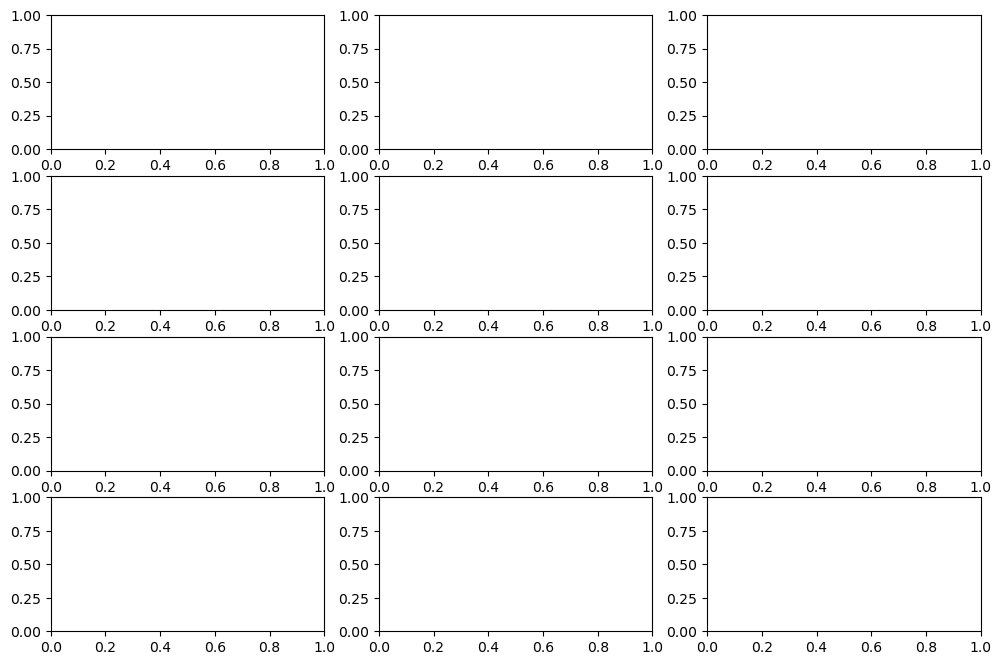

In [ ]:
n_steps = 5000

# compute default epsilon
x = X.reshape((X.shape[0], 1)).astype(float)
geom = pointcloud.PointCloud(x, x)
eps_default = geom.epsilon

# Number of rows and columns for the grid
rows, cols = 4, 3  # Adjust based on the number of plots
fig, axes = plt.subplots(rows, cols, figsize=(12, 8))

# Flatten the axes array for easy iteration if necessary
axes = axes.flatten()

for i, eps in enumerate(jnp.linspace(0, eps_default, 5)):
    learned, theta_init, loss_vals = learn_marginal_logits(mu_true, X, ot_marginal_loss, training_steps=n_steps, epsilon=eps)
    
    learned_mu_true = jax.nn.softmax(learned)
    axes[i].bar(X, learned_mu_true, label="learned marginal")
    axes[i].bar(X, mu_true, label="ground truth", color="green", alpha=0.25)
    axes[i].set_title(f"epsilon {eps}")
    
    w2_loss_vals, l2_loss_vals = loss_vals
    axes[6+i].plot(jnp.arange(1, n_steps+1, 1), w2_loss_vals, label="w2 loss")
    axes[6+i].plot(jnp.arange(1, n_steps+1, 1), l2_loss_vals, label="l2 loss")
# Hide any unused subplots if the grid has extra space
for j in range(5, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

Training Steps: 100%|██████████| 10000/10000 [02:02<00:00, 81.67step/s]


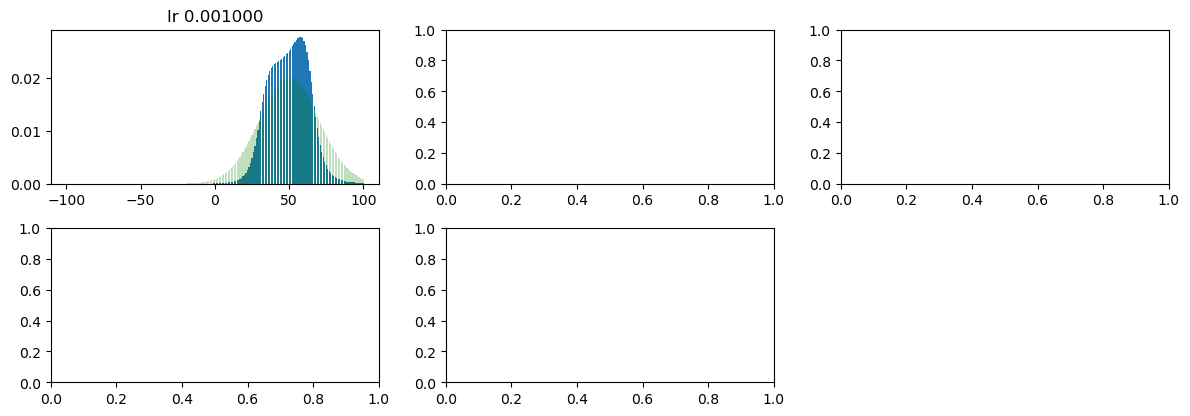

In [20]:
n_steps = 10000

# compute default epsilon
x = X.reshape((X.shape[0], 1)).astype(float)
geom = pointcloud.PointCloud(x, x)
eps_default = geom.epsilon

# Number of rows and columns for the grid
rows, cols = 4, 3  # Adjust based on the number of plots
fig, axes = plt.subplots(rows, cols, figsize=(12, 8))

# Flatten the axes array for easy iteration if necessary
axes = axes.flatten()

for i, lr in enumerate(jnp.linspace(1e-3, 1e-2, 1)):
    learned, theta_init, loss_vals = learn_marginal_logits(mu_true, X, ot_marginal_loss, training_steps=n_steps, epsilon=None, lr=lr)
    
    learned_mu_true = jax.nn.softmax(learned)
    axes[i].bar(X, learned_mu_true, label="learned marginal")
    axes[i].bar(X, mu_true, label="ground truth", color="green", alpha=0.25)
    axes[i].set_title(f"lr {lr:4f}")
    
#     w2_loss_vals, l2_loss_vals = loss_vals
#     axes[6+i].plot(jnp.arange(1, n_steps+1, 1), w2_loss_vals, label="w2 loss")
#     axes[6+i].plot(jnp.arange(1, n_steps+1, 1), l2_loss_vals, label="l2 loss")
# Hide any unused subplots if the grid has extra space
for j in range(5, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

### Training with different adam learning rates

In [ ]:
n_steps = 5000

lr_experiment_results = {}
for i, learning_rate in enumerate(jnp.linspace(0, 1e-2, 100)):
    learned, theta_init, loss_vals = learn_marginal_logits(mu_true, X, ot_marginal_loss, training_steps=n_steps, epsilon=None, lr=learning_rate)
    learned_mu_true = jax.nn.softmax(learned)
    lr_experiment_results[learning_rate] = learned_mu_true
    print(f"finished experiment {i} of 100")

In [267]:
lr_experiment_results.items()

dict_items([(0.0, Array([2.26734028e-06, 2.09559057e-05, 1.86886191e-05, 1.70104049e-05,
       5.59162390e-06, 1.11734822e-04, 8.60774962e-05, 1.41910286e-05,
       2.10300004e-05, 2.09279242e-05, 2.43607519e-05, 1.07697371e-04,
       2.80748536e-05, 4.67687350e-05, 2.58829982e-06, 1.20446311e-05,
       1.70514650e-05, 1.65161473e-05, 2.53319213e-05, 1.24079321e-04,
       4.35095644e-05, 4.25746694e-05, 1.54193403e-05, 5.67374591e-05,
       6.02854743e-06, 1.14888480e-05, 6.15196259e-05, 9.20812017e-05,
       1.03614575e-05, 5.28661149e-05, 2.82730634e-05, 5.62683053e-05,
       7.47118247e-05, 1.72157036e-06, 1.62514061e-05, 8.48630079e-05,
       9.77285235e-05, 1.69440245e-04, 5.59775981e-05, 6.64402833e-05,
       3.05979006e-06, 5.00544702e-05, 8.48919353e-06, 6.02934924e-05,
       4.46468130e-06, 5.32148078e-05, 8.10208348e-06, 5.38681525e-06,
       1.56698312e-04, 1.00995185e-05, 2.21633127e-05, 2.72793641e-05,
       3.94364833e-05, 7.41880867e-05, 3.43576066e-05, 7.31

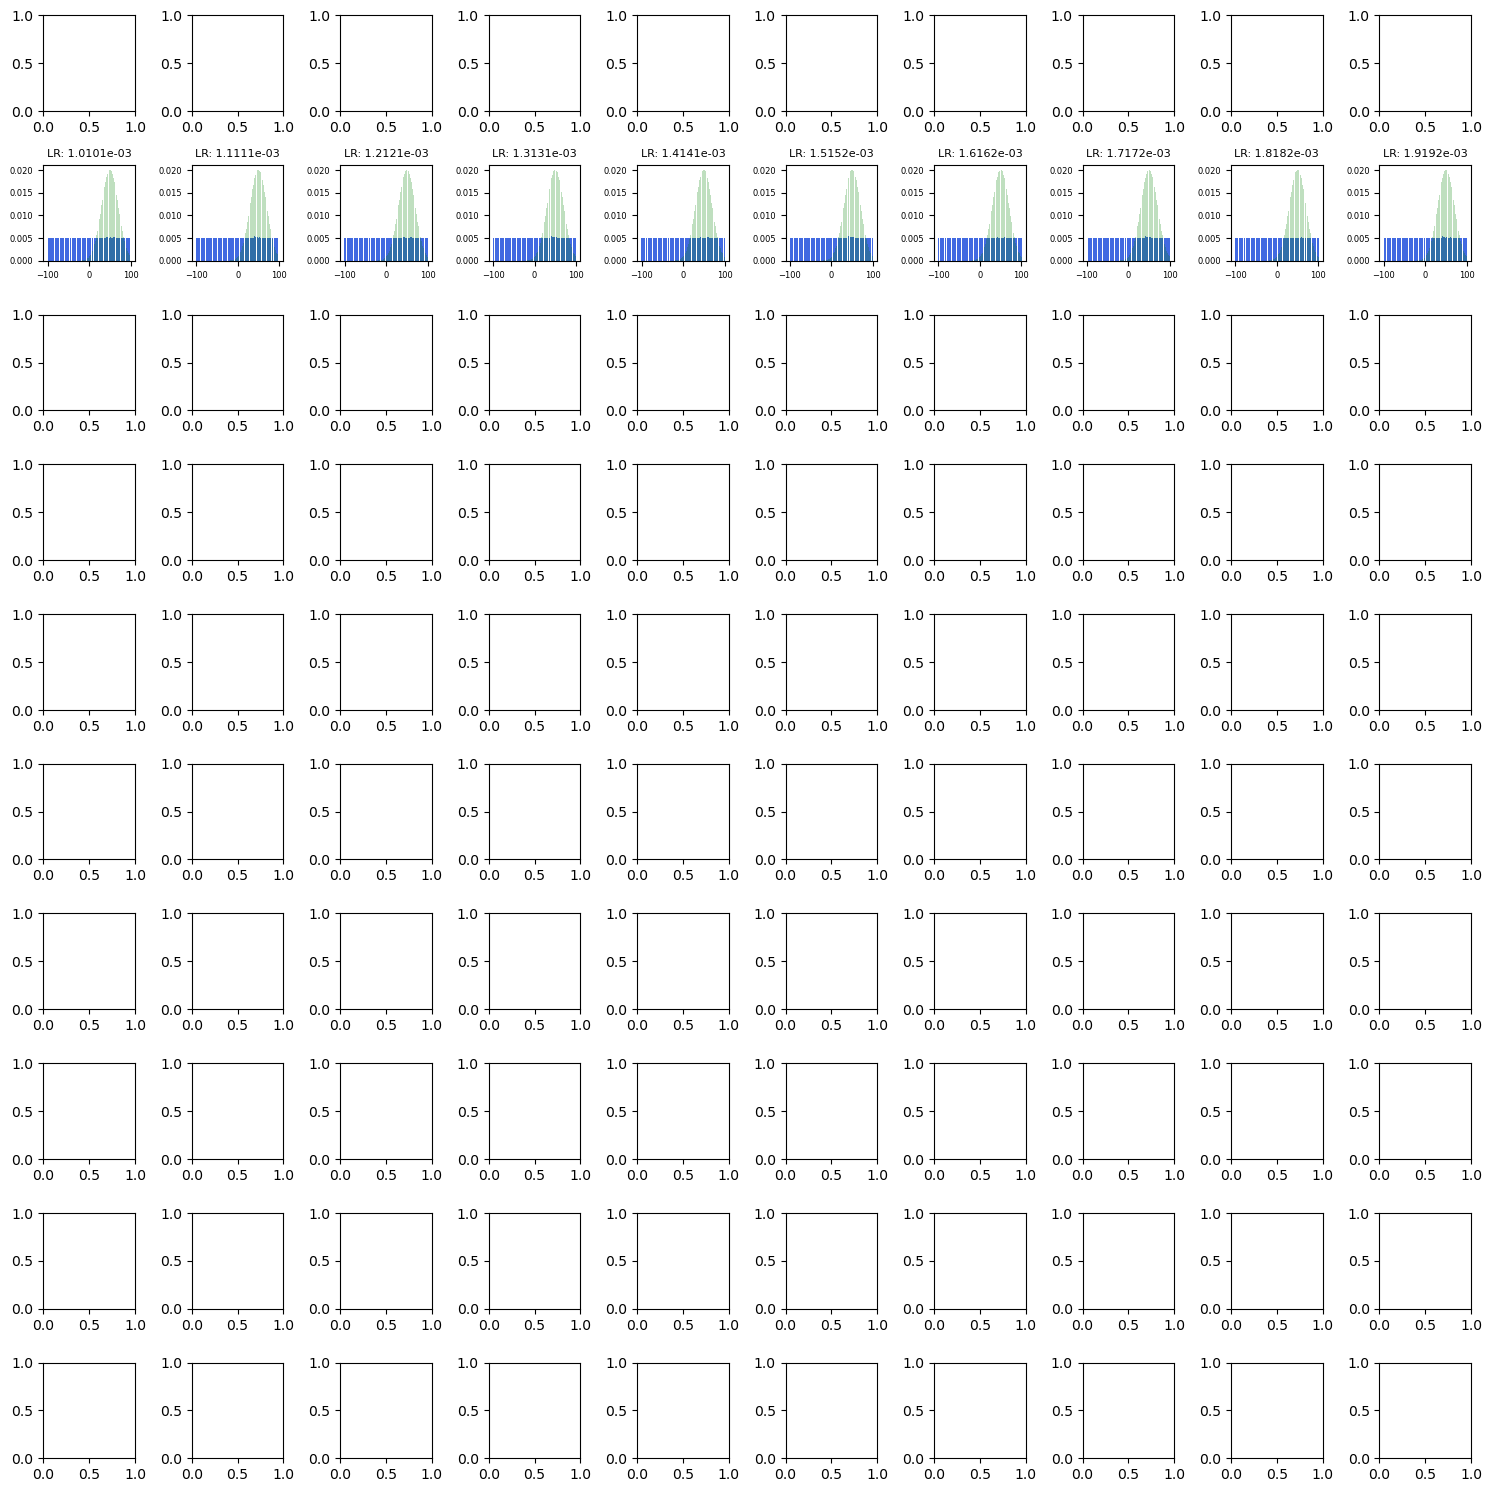

In [272]:
# plot results

n_steps = 5000
num_plots = 100  # Number of learning rates

# Compute a better grid layout (closer to square)
rows, cols = 10, 10  # 10x10 grid

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 15))  # Adjust size for readability
axes = axes.flatten()  # Flatten for easy iteration

# Iterate over learning rates
for i, result in list(enumerate(lr_experiment_results.items()))[10:20]:
    # Example function (replace with your learned data)
    lr, logits = result
    learned_marginal = jax.nn.softmax(logits)  # Example learned data

    # Plot bars
    axes[i].bar(X, learned_marginal, color="royalblue", label="Learned Marginal")
    axes[i].bar(X, mu_true, label="ground truth", color="green", alpha=0.25)
    # Title formatting
    axes[i].set_title(f"LR: {lr:.4e}", fontsize=8)  # Scientific notation for clarity
    axes[i].tick_params(axis="both", which="both", labelsize=6)  # Reduce tick label size

# Hide any extra unused subplots
for i in range(num_plots, len(axes)):
    fig.delaxes(axes[i])

# Adjust layout for better readability
plt.tight_layout(pad=1.0)  # Adjust padding
plt.show()

In [230]:
jnp.linspace(0, 1e-2, 100)

Array([0.        , 0.00010101, 0.00020202, 0.00030303, 0.00040404,
       0.00050505, 0.00060606, 0.00070707, 0.00080808, 0.00090909,
       0.0010101 , 0.00111111, 0.00121212, 0.00131313, 0.00141414,
       0.00151515, 0.00161616, 0.00171717, 0.00181818, 0.00191919,
       0.0020202 , 0.00212121, 0.00222222, 0.00232323, 0.00242424,
       0.00252525, 0.00262626, 0.00272727, 0.00282828, 0.00292929,
       0.0030303 , 0.00313131, 0.00323232, 0.00333333, 0.00343434,
       0.00353535, 0.00363636, 0.00373737, 0.00383838, 0.00393939,
       0.0040404 , 0.00414141, 0.00424242, 0.00434343, 0.00444444,
       0.00454545, 0.00464646, 0.00474747, 0.00484848, 0.00494949,
       0.00505051, 0.00515151, 0.00525253, 0.00535354, 0.00545455,
       0.00555556, 0.00565657, 0.00575758, 0.00585859, 0.0059596 ,
       0.00606061, 0.00616162, 0.00626263, 0.00636364, 0.00646465,
       0.00656566, 0.00666667, 0.00676768, 0.00686869, 0.0069697 ,
       0.00707071, 0.00717172, 0.00727273, 0.00737374, 0.00747

Training Steps: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [01:14<00:00, 53.76step/s]


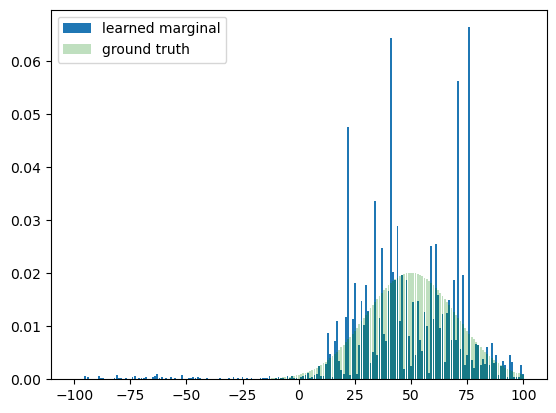

In [282]:
# plot learned distribution using ot.reg_ot_cost for ot comparison
learned, theta_init, _ = learn_marginal_logits(mu_true, X, ot_marginal_loss, training_steps=4000)
learned_mu_true = jax.nn.softmax(learned)
mu_init = jax.nn.softmax(theta_init[0])
plt.bar(X, learned_mu_true, label="learned marginal")
#plt.bar(X, mu_init, label="initial marginal", color="lightsteelblue")
plt.bar(X, mu_true, label="ground truth", color="green", alpha=0.25)
plt.legend()
plt.show()

In [ ]:
# plot learned distribution using w2 dist for ot comparison
learned, theta_init = learn_marginal_logits(mu_true, X, ot_marginal_loss_w2, training_steps=5000)
learned_mu_true = jax.nn.softmax(learned)
mu_init = jax.nn.softmax(theta_init[0])
plt.title("logit learning - ot.matrix")
plt.bar(X, learned_mu_true, label="learned marginal")
plt.bar(X, mu_init, label="initial marginal", color="lightsteelblue")
plt.bar(X, mu_true, label="ground truth", color="green", alpha=0.25)
plt.legend()
plt.show()

Training Steps: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:26<00:00, 57.53step/s]


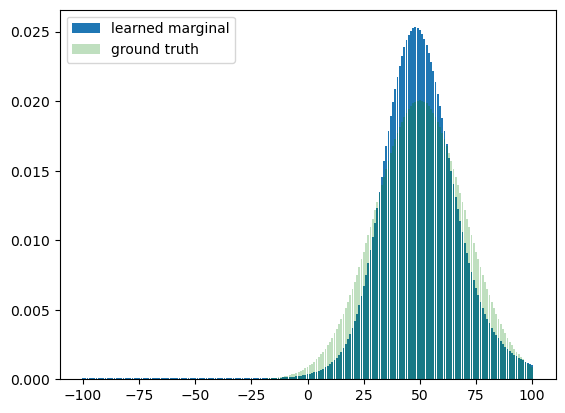

In [288]:
# plot learned distribution using ot.reg_ot_cost for ot comparison
learned, theta_init, _ = learn_marginal_logits(mu_true, X, ot_marginal_loss, training_steps=5000, lr=)
learned_mu_true = jax.nn.softmax(learned)
mu_init = jax.nn.softmax(theta_init[0])
plt.bar(X, learned_mu_true, label="learned marginal")
#plt.bar(X, mu_init, label="initial marginal", color="lightsteelblue")
plt.bar(X, mu_true, label="ground truth", color="green", alpha=0.25)
plt.legend()
plt.show()

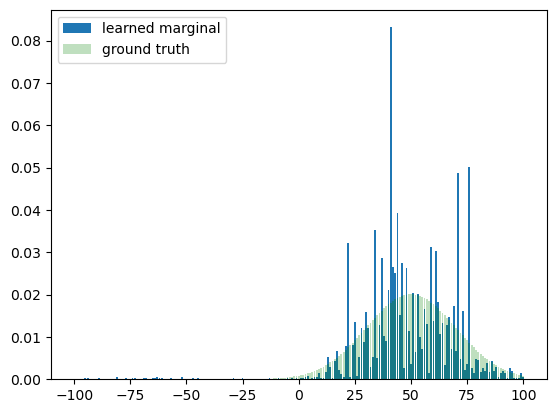

In [496]:
learned_mu_true = jax.nn.softmax(learned)
mu_init = jax.nn.softmax(theta_init[0])
plt.bar(X, learned_mu_true, label="learned marginal")
#plt.bar(X, mu_init, label="initial marginal", color="lightsteelblue")
plt.bar(X, mu_true, label="ground truth", color="green", alpha=0.25)
plt.legend()
plt.show()

iteration 0, loss value 4650.86181640625, l2 loss: 0.12481006234884262
iteration 1, loss value 4483.876953125, l2 loss: 0.12406411021947861
iteration 2, loss value 4320.31103515625, l2 loss: 0.12338995188474655
iteration 3, loss value 4160.35107421875, l2 loss: 0.12278896570205688
iteration 4, loss value 4004.204833984375, l2 loss: 0.12226098775863647
iteration 5, loss value 3852.05615234375, l2 loss: 0.12180448323488235
iteration 6, loss value 3704.067138671875, l2 loss: 0.12141726911067963
iteration 7, loss value 3560.379638671875, l2 loss: 0.1210964024066925
iteration 8, loss value 3419.44091796875, l2 loss: 0.1208382248878479
iteration 9, loss value 3284.794921875, l2 loss: 0.12063856422901154
iteration 10, loss value 3154.705078125, l2 loss: 0.12049291282892227
iteration 11, loss value 3029.18212890625, l2 loss: 0.12039678543806076
iteration 12, loss value 2908.22607421875, l2 loss: 0.12034587562084198
iteration 13, loss value 2791.8115234375, l2 loss: 0.12033618241548538
iteratio

iteration 123, loss value 325.7107238769531, l2 loss: 0.1233234629034996
iteration 124, loss value 323.4732360839844, l2 loss: 0.1230984777212143
iteration 125, loss value 321.2709045410156, l2 loss: 0.12287236005067825
iteration 126, loss value 319.1080017089844, l2 loss: 0.1226452887058258
iteration 127, loss value 316.981201171875, l2 loss: 0.1224173754453659
iteration 128, loss value 314.89056396484375, l2 loss: 0.1221887394785881
iteration 129, loss value 312.8337097167969, l2 loss: 0.12195949256420135
iteration 130, loss value 310.8109436035156, l2 loss: 0.1217297911643982
iteration 131, loss value 308.82403564453125, l2 loss: 0.12149970233440399
iteration 132, loss value 306.8692626953125, l2 loss: 0.12126939743757248
iteration 133, loss value 304.9458312988281, l2 loss: 0.12103898078203201
iteration 134, loss value 303.0544738769531, l2 loss: 0.12080858647823334
iteration 135, loss value 301.1954040527344, l2 loss: 0.12057828903198242
iteration 136, loss value 299.3653869628906

iteration 243, loss value 209.66848754882812, l2 loss: 0.1075458750128746
iteration 244, loss value 209.38790893554688, l2 loss: 0.10752110928297043
iteration 245, loss value 209.1117401123047, l2 loss: 0.10749687254428864
iteration 246, loss value 208.84109497070312, l2 loss: 0.10747309029102325
iteration 247, loss value 208.57362365722656, l2 loss: 0.10744982212781906
iteration 248, loss value 208.31300354003906, l2 loss: 0.10742699354887009
iteration 249, loss value 208.05287170410156, l2 loss: 0.10740454494953156
iteration 250, loss value 207.80062866210938, l2 loss: 0.10738249868154526
iteration 251, loss value 207.55140686035156, l2 loss: 0.10736083984375
iteration 252, loss value 207.30735778808594, l2 loss: 0.1073395162820816
iteration 253, loss value 207.0670166015625, l2 loss: 0.10731850564479828
iteration 254, loss value 206.83047485351562, l2 loss: 0.10729778558015823
iteration 255, loss value 206.5984344482422, l2 loss: 0.10727736353874207
iteration 256, loss value 206.368

iteration 354, loss value 194.2639617919922, l2 loss: 0.10532788187265396
iteration 355, loss value 194.1941375732422, l2 loss: 0.10530658811330795
iteration 356, loss value 194.1246795654297, l2 loss: 0.10528533160686493
iteration 357, loss value 194.0572967529297, l2 loss: 0.1052640751004219
iteration 358, loss value 193.9886016845703, l2 loss: 0.10524284094572067
iteration 359, loss value 193.92071533203125, l2 loss: 0.10522162914276123
iteration 360, loss value 193.85462951660156, l2 loss: 0.10520045459270477
iteration 361, loss value 193.7882080078125, l2 loss: 0.10517928004264832
iteration 362, loss value 193.71957397460938, l2 loss: 0.10515815764665604
iteration 363, loss value 193.65481567382812, l2 loss: 0.10513705015182495
iteration 364, loss value 193.59056091308594, l2 loss: 0.10511598736047745
iteration 365, loss value 193.5246124267578, l2 loss: 0.10509492456912994
iteration 366, loss value 193.4604034423828, l2 loss: 0.10507390648126602
iteration 367, loss value 193.3966

iteration 471, loss value 188.1583709716797, l2 loss: 0.10315755009651184
iteration 472, loss value 188.11781311035156, l2 loss: 0.10314243286848068
iteration 473, loss value 188.0790557861328, l2 loss: 0.1031273826956749
iteration 474, loss value 188.0382080078125, l2 loss: 0.10311238467693329
iteration 475, loss value 187.99794006347656, l2 loss: 0.10309746116399765
iteration 476, loss value 187.9588165283203, l2 loss: 0.1030825823545456
iteration 477, loss value 187.91824340820312, l2 loss: 0.1030677780508995
iteration 478, loss value 187.87928771972656, l2 loss: 0.1030530259013176
iteration 479, loss value 187.840576171875, l2 loss: 0.10303833335638046
iteration 480, loss value 187.80072021484375, l2 loss: 0.10302369296550751
iteration 481, loss value 187.7612762451172, l2 loss: 0.10300912708044052
iteration 482, loss value 187.72256469726562, l2 loss: 0.10299460589885712
iteration 483, loss value 187.6844940185547, l2 loss: 0.10298016667366028
iteration 484, loss value 187.6461944

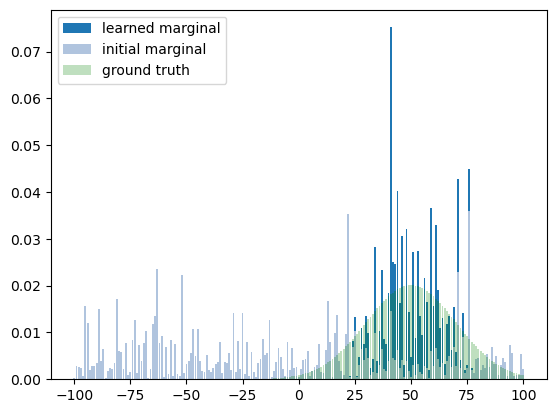

In [490]:
# plot learned distribution using ot.primal_cost for ot comparison
learned, theta_init = learn_marginal_logits(mu_true, X, ot_marginal_loss_primal)
learned_mu_true = jax.nn.softmax(learned)
mu_init = jax.nn.softmax(theta_init[0])
plt.bar(X, learned_mu_true, label="learned marginal")
plt.bar(X, mu_init, label="initial marginal", color="lightsteelblue")
plt.bar(X, mu_true, label="ground truth", color="green", alpha=0.25)
plt.legend()
plt.show()

In [415]:
# initialize a random array
key = jax.random.PRNGKey(42)
key, subkey = jax.random.split(key)
theta = jax.random.normal(key=subkey, shape=X.shape)
X_reshaped = X.reshape(X.shape[0], 1).astype(float)

logit_loss(theta, mu_true, X_reshaped)
#learn_marginal_logits(mu_true)

#jax.grad(logit_loss)(theta, mu_true, X=X_reshaped)

#mu = gaussian_kernel(0, 1, X)
#X_reshaped = X.reshape(X.shape[0], 1).astype(float)
#jax.grad(ot_marginal_loss)(mu, mu_true, X_reshaped)
#jax.grad(loss)(jnp.array(0.1), mu_true, X)

Array(3285.7407, dtype=float32)

In [72]:
a = jnp.arange(4)
b = jnp.arange(5)
X, Y = jnp.meshgrid(a, b, indexing="ij")
XY = jnp.stack([X, Y], axis=-1).reshape((20, 2))
XY
#ot_marginal_loss

Array([[0, 0],
       [0, 1],
       [0, 2],
       [0, 3],
       [0, 4],
       [1, 0],
       [1, 1],
       [1, 2],
       [1, 3],
       [1, 4],
       [2, 0],
       [2, 1],
       [2, 2],
       [2, 3],
       [2, 4],
       [3, 0],
       [3, 1],
       [3, 2],
       [3, 3],
       [3, 4]], dtype=int32)

## Checking gradients at optima
- Check the gradient of `logit_loss` and `logit_l2_loss` at the logits of `mu_true`. Both should be close to 0.

In [305]:
mu_true_logits = jnp.log(mu_true)
X_reshaped = X.reshape((X.shape[0], 1)).astype(float)
print(jax.value_and_grad(logit_loss)(mu_true_logits, mu_true, X_reshaped))
print(jax.value_and_grad(logit_l2_loss)(mu_true_logits, mu_true))

(Array(354.75955, dtype=float32), Array([ 5.91730692e-11,  8.48221771e-11,  1.21274615e-10,  1.72944006e-10,
        2.45988646e-10,  3.48978457e-10,  4.93803720e-10,  6.96917413e-10,
        9.81023707e-10,  1.37735912e-09,  1.92878402e-09,  2.69393974e-09,
        3.75283760e-09,  5.21432231e-09,  7.22605575e-09,  9.98780347e-09,
        1.37689913e-08,  1.89320204e-08,  2.59629385e-08,  3.55117642e-08,
        4.84452123e-08,  6.59156214e-08,  8.94509213e-08,  1.21070585e-07,
        1.63436383e-07,  2.20046246e-07,  2.95484114e-07,  3.95737800e-07,
        5.28607075e-07,  7.04221634e-07,  9.35699575e-07,  1.23997268e-06,
        1.63883465e-06,  2.16025705e-06,  2.84001430e-06,  3.72374097e-06,
        4.86945692e-06,  6.35073320e-06,  8.26050200e-06,  1.07158585e-05,
        1.38638752e-05,  1.78886530e-05,  2.30199275e-05,  2.95434984e-05,
        3.78138502e-05,  4.82689902e-05,  6.14485762e-05,  7.80155096e-05,
        9.87806488e-05,  1.24733881e-04,  1.57078292e-04,  1.97271

In [308]:
X_reshaped = X.reshape((X.shape[0], 1)).astype(float)
key = jax.random.PRNGKey(42)
theta_random = jax.random.uniform(key, shape=mu_true.shape)
mu_random = jax.nn.softmax(theta_random)
jax.value_and_grad(ot_marginal_loss_w2)(mu_true, mu_true, X_reshaped, 350)

(Array(154.86775, dtype=float32),
 Array([-1.80647696e+08, -1.75727440e+08, -1.48247088e+08, -1.23378840e+08,
        -9.60261040e+07, -7.24984800e+07, -5.35959560e+07, -3.92706600e+07,
        -2.80846600e+07, -1.96991480e+07, -1.37300850e+07, -9.38749500e+06,
        -6.31088400e+06, -4.24091750e+06, -2.74364525e+06, -1.77223262e+06,
        -1.11008025e+06, -6.69161250e+05, -3.82380406e+05, -2.05985109e+05,
        -9.65393203e+04, -3.46024023e+04,  5.11872119e+03,  2.11264766e+04,
         3.00241465e+04,  3.20303223e+04,  2.87158926e+04,  2.51495703e+04,
         2.06283770e+04,  1.70353164e+04,  1.32619805e+04,  1.02495547e+04,
         7.75344434e+03,  5.77136963e+03,  4.17974365e+03,  3.01830713e+03,
         2.12273438e+03,  1.47143066e+03,  1.02173724e+03,  6.87751221e+02,
         4.70363068e+02,  3.14361267e+02,  2.22429352e+02,  1.66831055e+02,
         1.36861145e+02,  1.26983986e+02,  1.25625473e+02,  1.31058121e+02,
         1.38034973e+02,  1.48144379e+02,  1.56492950e